In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [560]:
data = pd.read_csv('train.csv')
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [283]:
data_store_1 = data[data['Store']==1][['Date', 'Sales']]
data_store_1.set_index('Date', inplace=True)
data_store_1.sort_index(ascending=True, inplace=True)

### Forecasting with SARIMA models

#### 1st model: SARIMA with 0s replaced with 5-day centered moving average
- Predictions are not good, especially for sales in the long term.

In [330]:
data_store_1.shape

(942, 1)

<AxesSubplot: xlabel='Date'>

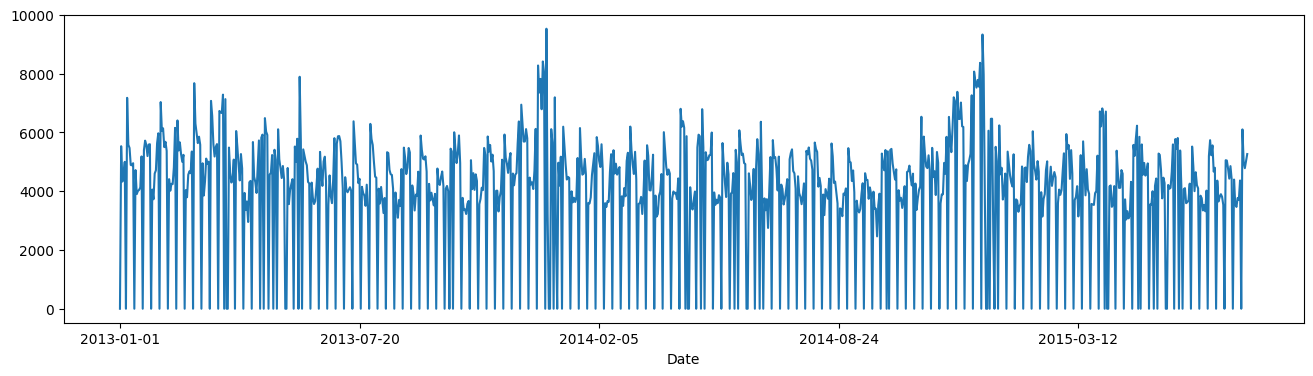

In [331]:
data_store_1['Sales'].plot(figsize=[16, 4])

In [569]:
# There are many records with sales of 0 meaning the store was closed.
# Replace 0s with the average of 2 preceding and 2 following values
# Since I need to calculate seasonal difference of time series, I want to impute 0s instead of removing them, which will cause more values to be removed.
data_store_1_union = data_store_1.rolling(5, min_periods=0, center=True).mean().loc[data_store_1[data_store_1['Sales']==0].index.values]
data_store_1_processed = pd.concat([data_store_1[data_store_1['Sales']!=0], data_store_1_union]).sort_index()

<AxesSubplot: xlabel='Date'>

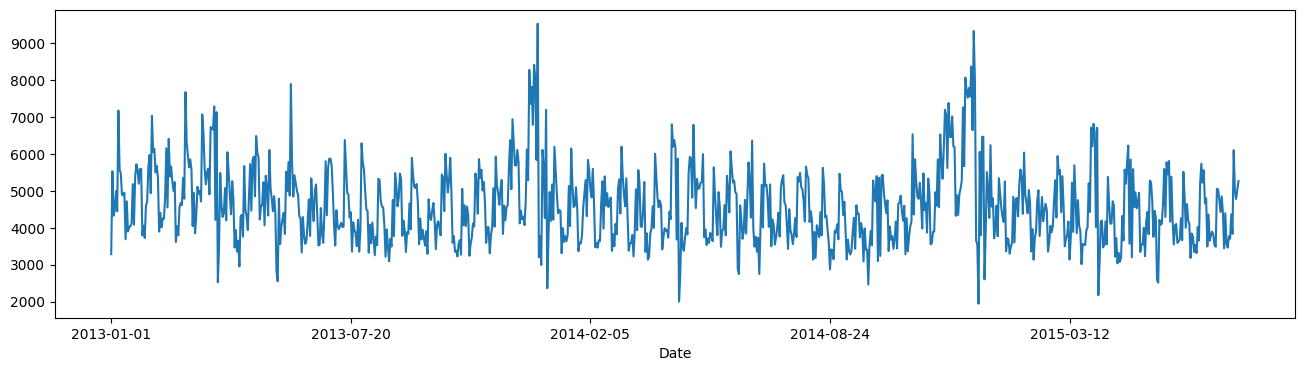

In [570]:
data_store_1_processed['Sales'].plot(figsize=[16, 4])

In [674]:
# The data observe strong seasonality, so I'm going to take a seasonal difference to see if this makes the data stationary
# strftime converts datetime data into string
# Spike in sales is observed every 13 days
data_store_1_processed['sdiff_sales'] = 0
for i in range(13, len(data_store_1_processed)):
    data_store_1_processed.iloc[i, 1] = data_store_1_processed.iloc[i, 0] \
        - data_store_1_processed.loc[(pd.to_datetime(data_store_1_processed.index[i])-timedelta(days=13)).strftime('%Y-%m-%d'), 'Sales']

<AxesSubplot: xlabel='Date'>

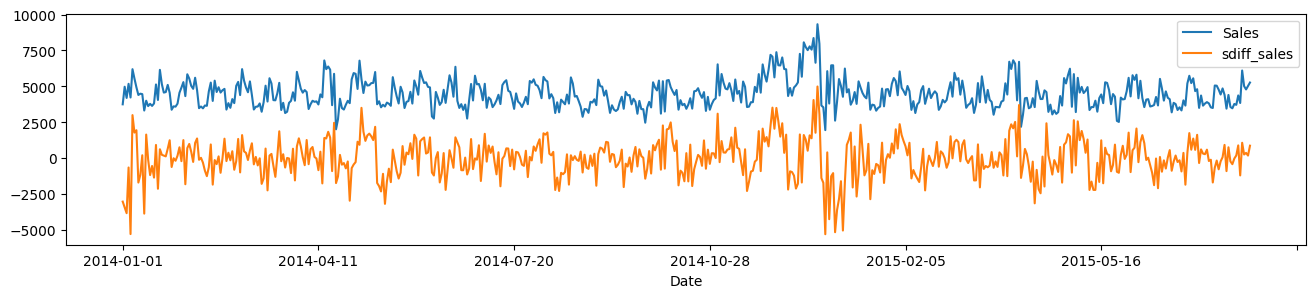

In [676]:
# Seasonality becomes weaker but still seems to exist
data_store_1_processed[['Sales', 'sdiff_sales']]['2014-01-01':].plot(figsize=[16, 3])

In [677]:
# Use KPSS test to test for stationarity
# p-value of the test is 0.1, higher than 0.05, so fail to reject the null hypothesis, and seasonally differenced data is stationary. It appears weakly stationary.
kpss(data_store_1_processed.iloc[13:, 1].values)

(0.013640072301663551,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

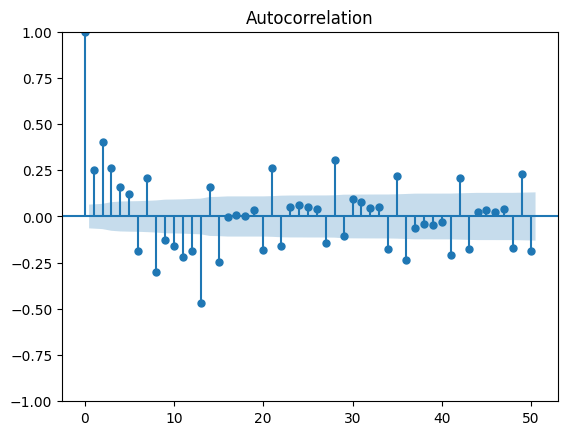

In [679]:
# ACF and PACF plots of the differenced data
# Based on the plots, there are still strong correlations existing in differenced data.
plot_acf(data_store_1_processed.iloc[13:, 1], lags=50);

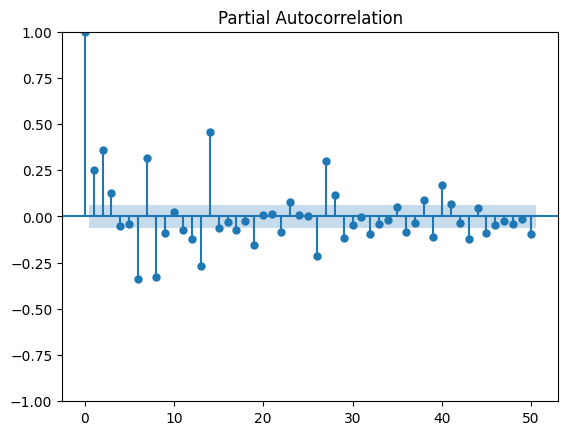

In [680]:
plot_pacf(data_store_1_processed.iloc[13:, 1], lags=50);

In [652]:
# Since it's hard to determine appropriate values for p and q using the plots, decide to run an auto seasonal ARIMA model to determine their values.
auto_arima(data_store_1_processed['Sales'], seasonal=True, m=13, with_intercept=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  942
Model:             SARIMAX(4, 0, 2)x(2, 0, 2, 13)   Log Likelihood               -7604.006
Date:                            Sun, 16 Jul 2023   AIC                          15232.012
Time:                                    16:08:19   BIC                          15290.188
Sample:                                01-01-2013   HQIC                         15254.187
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2311.3794    679.352      3.402      0.001     979.873    3642.885
ar.L1         -1.2654      0.039    -32.491      0.000      -1.342      -1.189
ar.L2          0.1035      0.044      2.339      0.019       0.017       0.190
ar.L3          0.7888      0.046     17.203      0.000       0.699       0.879
ar.L4          0.1474      0.038      3.858      0.000       0.073       0.222
ma.L1          1.7527      0.020     87.202      0.000       1.713       1.792
ma.L2          0.9308      0.019     48.660      0.000       0.893       0.968
ar.S.L13       0.2462      0.165      1.490      0.136      -0.078       0.570
ar.S.L26       0.3435      0.138      2.496      0.013       0.074       0.613
ma.S.L13      -0.0665      0.158     -0.421      0.674      -0.376       0.243
ma.S.L26      -0.4743      0.123     -3.847      0.000      -0.716      -0.233
sigma2      6.702e+05   2.85e+04     23.508      0.000    6.14e+05    7.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):               155.46
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.20
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.35e+16. Standard errors may be unstable.
"""

In [838]:
# Split data into train and test sets
train = data_store_1_processed.iloc[:753, 0]
test = data_store_1_processed.iloc[753:, 0]

In [839]:
# Fit seasonal ARIMA model
sarima_model_1 = SARIMAX(train, order=(4, 0, 2), seasonal_order=(2, 0, 2, 13), trend='c')
model_1 = sarima_model_1.fit()
model_1.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63358D+02    |proj g|=  1.05223D+03

At iterate    5    f=  9.89176D+00    |proj g|=  1.05074D+00

At iterate   10    f=  8.95798D+00    |proj g|=  3.04855D-01

At iterate   15    f=  8.34265D+00    |proj g|=  5.04325D-01

At iterate   20    f=  8.14102D+00    |proj g|=  1.58767D-01

At iterate   25    f=  8.12552D+00    |proj g|=  5.86106D-02

At iterate   30    f=  8.11376D+00    |proj g|=  1.63779D-02

At iterate   35    f=  8.11199D+00    |proj g|=  5.68370D-02

At iterate   40    f=  8.11113D+00    |proj g|=  3.72416D-03

At iterate   45    f=  8.11011D+00    |proj g|=  1.02696D-02

At iterate   50    f=  8.10739D+00    |proj g|=  4.63304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  753
Model:             SARIMAX(4, 0, 2)x(2, 0, 2, 13)   Log Likelihood               -6104.864
Date:                            Mon, 17 Jul 2023   AIC                          12233.728
Time:                                    21:02:10   BIC                          12289.217
Sample:                                01-01-2013   HQIC                         12255.105
                                     - 01-23-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2195.8731   2143.072      1.025      0.306   -2004.471    6396.217
ar.L1         -1.2423      0.037    -33.236      0.000      -1.316      -1.169
ar.L2          0.1219      0.043      2.834      0.005       0.038       0.206
ar.L3          0.7707      0.047     16.436      0.000       0.679       0.863
ar.L4          0.1228      0.038      3.211      0.001       0.048       0.198
ma.L1          1.7768      0.017    106.170      0.000       1.744       1.810
ma.L2          0.9608      0.016     59.972      0.000       0.929       0.992
ar.S.L13       1.2537      0.715      1.754      0.079      -0.147       2.655
ar.S.L26      -0.6368      0.500     -1.275      0.202      -1.616       0.342
ma.S.L13      -1.2129      0.712     -1.704      0.088      -2.608       0.182
ma.S.L26       0.6301      0.472      1.334      0.182      -0.296       1.556
sigma2       7.06e+05     19.090    3.7e+04      0.000    7.06e+05    7.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):               200.12
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.26
Prob(H) (two-sided):                  0.28   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+20. Standard errors may be unstable.
"""

<AxesSubplot: xlabel='Date'>

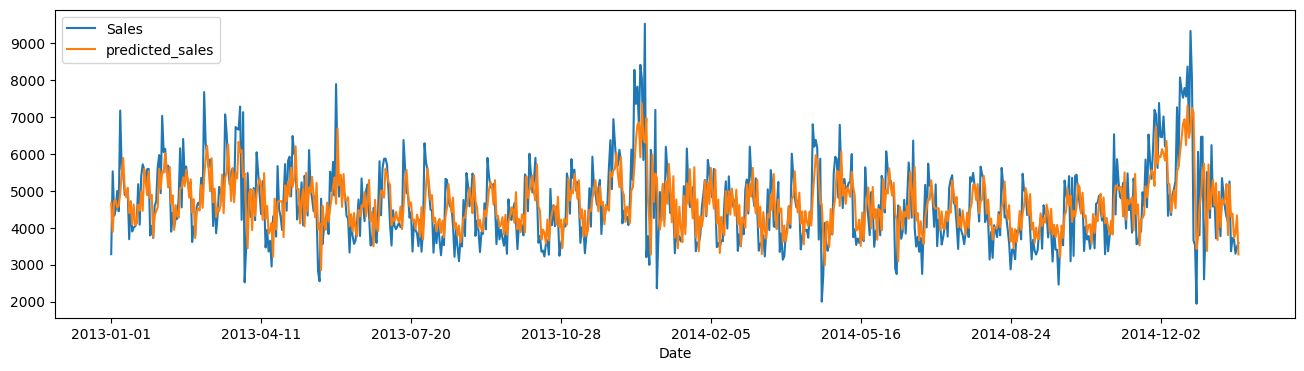

In [709]:
# Plot actual sales vs. predicted sales using train data
train_prediction = pd.concat([train.reset_index(), model_1.predict(start=0, end=len(train)-1).reset_index(drop=True)], axis=1)\
    .rename(columns={'predicted_mean':'predicted_sales'})
train_prediction.set_index('Date', inplace=True)
train_prediction[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

<AxesSubplot: xlabel='Date'>

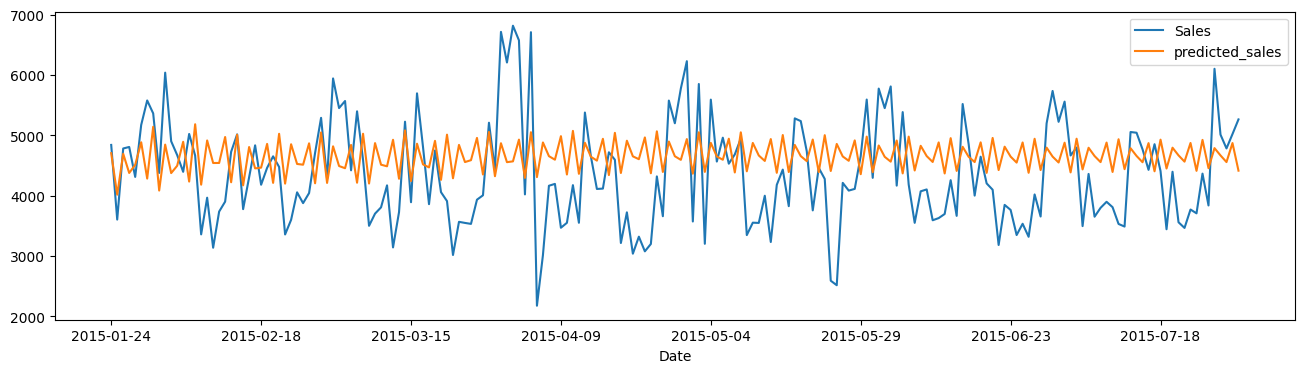

In [720]:
# Plot of actual sales vs. predicted sales in test data
# Predictions are not good, especially for data in the long term.
model_1_predictions = model_1.predict(start=len(train), end=len(data_store_1_processed)-1)
model_1_results = pd.concat([pd.DataFrame(test).reset_index(), pd.DataFrame(model_1_predictions).reset_index(drop=True)], axis=1)\
    .rename(columns={'predicted_mean':'predicted_sales'})
model_1_results.set_index('Date')[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [731]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {}'.format(mean_squared_error(model_1_results['Sales'][:14], model_1_results['predicted_sales'][:14], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_1_results['Sales'][:14], model_1_results['predicted_sales'][:14])))

MSE: 592.8531713094459
MAPE: 9.34%


##### Tune the value of m to see if model performance can be improved
- Changing m from 13 to 21 largely improves model performance. MAPE decreased to 6.6% from 9.3%.
    - m of 21 probably means people usually go to store once every 21 days.
- Next step is to see if different values of p and q result in improvement. Will also need to test if differencing makes a difference.

In [736]:
# Check if tuning the value of m can improve model performance
m_values = []
rmse_values = []
mape_values = []
for m in range(5, 30):
    sarimax_model = SARIMAX(train, order=(4, 0, 2), seasonal_order=(2, 0, 2, m), trend='c')
    model_1_m = sarimax_model.fit()
    model_1_m_predictions = model_1_m.predict(start=len(train), end=len(data_store_1_processed)-1)
    model_1_m_results = pd.concat([pd.DataFrame(test).reset_index(), pd.DataFrame(model_1_m_predictions).reset_index(drop=True)], axis=1)\
        .rename(columns={'predicted_mean':'predicted_sales'})
    m_values.append(m)
    rmse_values.append(mean_squared_error(model_1_m_results['Sales'][:14], model_1_m_results['predicted_sales'][:14], squared=False))
    mape_values.append(mean_absolute_percentage_error(model_1_m_results['Sales'][:14], model_1_m_results['predicted_sales'][:14]))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38321D+02    |proj g|=  3.26845D+02


 This problem is unconstrained.



At iterate    5    f=  9.12948D+00    |proj g|=  2.72933D-01

At iterate   10    f=  8.68573D+00    |proj g|=  1.54033D-01

At iterate   15    f=  8.38631D+00    |proj g|=  7.68128D-01

At iterate   20    f=  8.16631D+00    |proj g|=  6.60788D-02

At iterate   25    f=  8.15349D+00    |proj g|=  1.57308D-01

At iterate   30    f=  8.12378D+00    |proj g|=  1.07918D-01

At iterate   35    f=  8.11963D+00    |proj g|=  1.82500D-02

At iterate   40    f=  8.09810D+00    |proj g|=  1.71321D-01

At iterate   45    f=  8.08595D+00    |proj g|=  8.15748D-03

At iterate   50    f=  8.08570D+00    |proj g|=  3.03794D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.13506D+01    |proj g|=  6.65887D+00

At iterate   10    f=  9.18391D+00    |proj g|=  5.05369D-01

At iterate   15    f=  8.33064D+00    |proj g|=  4.08584D-01

At iterate   20    f=  8.12463D+00    |proj g|=  1.35578D-01

At iterate   25    f=  8.11149D+00    |proj g|=  4.31807D-02

At iterate   30    f=  8.10209D+00    |proj g|=  2.78983D-02

At iterate   35    f=  8.10113D+00    |proj g|=  2.65733D-02

At iterate   40    f=  8.09950D+00    |proj g|=  1.63228D-02

At iterate   45    f=  8.09874D+00    |proj g|=  5.11337D-03

At iterate   50    f=  8.09783D+00    |proj g|=  2.41581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  8.50479D+00    |proj g|=  1.92641D-01

At iterate   15    f=  8.10725D+00    |proj g|=  1.33714D-01

At iterate   20    f=  8.05097D+00    |proj g|=  6.75768D-02

At iterate   25    f=  8.04823D+00    |proj g|=  1.51617D-02

At iterate   30    f=  8.04714D+00    |proj g|=  5.35884D-03

At iterate   35    f=  8.04540D+00    |proj g|=  2.61626D-02

At iterate   40    f=  8.04059D+00    |proj g|=  1.47537D-02

At iterate   45    f=  8.03870D+00    |proj g|=  2.31593D-02

At iterate   50    f=  8.03753D+00    |proj g|=  2.03430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58   

 This problem is unconstrained.



At iterate    5    f=  9.33366D+00    |proj g|=  4.84141D-01

At iterate   10    f=  8.40230D+00    |proj g|=  6.61048D-01

At iterate   15    f=  8.17005D+00    |proj g|=  1.11073D-01

At iterate   20    f=  8.13962D+00    |proj g|=  9.07066D-02

At iterate   25    f=  8.11934D+00    |proj g|=  2.28007D-01

At iterate   30    f=  8.10448D+00    |proj g|=  9.84535D-03

At iterate   35    f=  8.10252D+00    |proj g|=  5.10396D-02

At iterate   40    f=  8.10189D+00    |proj g|=  5.65289D-03

At iterate   45    f=  8.10124D+00    |proj g|=  4.33467D-03

At iterate   50    f=  8.10090D+00    |proj g|=  4.65124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.28739D+00    |proj g|=  4.12663D-01

At iterate   10    f=  8.78706D+00    |proj g|=  2.04768D-01

At iterate   15    f=  8.26143D+00    |proj g|=  4.63329D-01

At iterate   20    f=  8.08360D+00    |proj g|=  2.87342D-02

At iterate   25    f=  8.07931D+00    |proj g|=  2.27387D-02

At iterate   30    f=  8.07805D+00    |proj g|=  3.46796D-02

At iterate   35    f=  8.07696D+00    |proj g|=  1.16949D-02

At iterate   40    f=  8.07537D+00    |proj g|=  1.56620D-02

At iterate   45    f=  8.07298D+00    |proj g|=  2.48411D-02

At iterate   50    f=  8.07185D+00    |proj g|=  7.65513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81017D+02    |proj g|=  1.30297D+03

At iterate    5    f=  1.00226D+01    |proj g|=  2.36071D+00

At iterate   10    f=  9.09580D+00    |proj g|=  4.35028D-01

At iterate   15    f=  8.58398D+00    |proj g|=  1.81515D-01

At iterate   20    f=  8.11925D+00    |proj g|=  2.84029D-02

At iterate   25    f=  8.10811D+00    |proj g|=  3.77996D-02

At iterate   30    f=  8.10218D+00    |proj g|=  7.16172D-03

At iterate   35    f=  8.10139D+00    |proj g|=  1.42274D-02

At iterate   40    f=  8.09875D+00    |proj g|=  6.78335D-03

At iterate   45    f=  8.09577D+00    |proj g|=  1.06280D-01

At iterate   50    f=  8.09108D+00    |proj g|=  6.53292D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  2.40520D+01    |proj g|=  2.38569D+01

At iterate   10    f=  9.60566D+00    |proj g|=  8.41719D-01

At iterate   15    f=  8.17629D+00    |proj g|=  2.80886D-01

At iterate   20    f=  8.14448D+00    |proj g|=  2.98162D-02

At iterate   25    f=  8.13820D+00    |proj g|=  3.29509D-02

At iterate   30    f=  8.09905D+00    |proj g|=  7.12396D-02

At iterate   35    f=  8.08671D+00    |proj g|=  3.71012D-02

At iterate   40    f=  8.07918D+00    |proj g|=  8.08602D-02

At iterate   45    f=  8.06733D+00    |proj g|=  1.18308D-01

At iterate   50    f=  8.06165D+00    |proj g|=  4.33753D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.10490D+01    |proj g|=  5.38647D+00

At iterate   10    f=  9.09489D+00    |proj g|=  2.73145D-01

At iterate   15    f=  8.75968D+00    |proj g|=  2.85915D-01

At iterate   20    f=  8.16961D+00    |proj g|=  2.11430D-01

At iterate   25    f=  8.12575D+00    |proj g|=  4.78198D-02

At iterate   30    f=  8.10348D+00    |proj g|=  2.36494D-02

At iterate   35    f=  8.09703D+00    |proj g|=  5.71021D-02

At iterate   40    f=  8.09573D+00    |proj g|=  6.39278D-03

At iterate   45    f=  8.09489D+00    |proj g|=  6.48205D-03

At iterate   50    f=  8.09421D+00    |proj g|=  3.03183D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.89176D+00    |proj g|=  1.05074D+00

At iterate   10    f=  8.95798D+00    |proj g|=  3.04855D-01

At iterate   15    f=  8.34265D+00    |proj g|=  5.04325D-01

At iterate   20    f=  8.14102D+00    |proj g|=  1.58767D-01

At iterate   25    f=  8.12552D+00    |proj g|=  5.86106D-02

At iterate   30    f=  8.11376D+00    |proj g|=  1.63779D-02

At iterate   35    f=  8.11199D+00    |proj g|=  5.68370D-02

At iterate   40    f=  8.11113D+00    |proj g|=  3.72416D-03

At iterate   45    f=  8.11011D+00    |proj g|=  1.02696D-02

At iterate   50    f=  8.10739D+00    |proj g|=  4.63304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.07794D+00    |proj g|=  4.13459D-01

At iterate   10    f=  8.57219D+00    |proj g|=  1.30316D-01

At iterate   15    f=  8.10209D+00    |proj g|=  1.87362D-01

At iterate   20    f=  8.04694D+00    |proj g|=  3.22974D-02

At iterate   25    f=  8.04165D+00    |proj g|=  1.73271D-03

At iterate   30    f=  8.03969D+00    |proj g|=  1.06224D-02

At iterate   35    f=  8.03850D+00    |proj g|=  7.23893D-03

At iterate   40    f=  8.03832D+00    |proj g|=  2.49200D-03

At iterate   45    f=  8.03558D+00    |proj g|=  7.40624D-02

At iterate   50    f=  8.03309D+00    |proj g|=  4.52284D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.32388D+00    |proj g|=  7.50950D-01

At iterate   10    f=  8.37354D+00    |proj g|=  6.74264D-01

At iterate   15    f=  8.15683D+00    |proj g|=  9.07535D-02

At iterate   20    f=  8.12937D+00    |proj g|=  9.47855D-02

At iterate   25    f=  8.11495D+00    |proj g|=  9.77162D-03

At iterate   30    f=  8.11296D+00    |proj g|=  9.93559D-03

At iterate   35    f=  8.11128D+00    |proj g|=  2.80012D-02

At iterate   40    f=  8.11001D+00    |proj g|=  2.61478D-02

At iterate   45    f=  8.10212D+00    |proj g|=  4.71787D-02

At iterate   50    f=  8.09731D+00    |proj g|=  3.88236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.36382D+00    |proj g|=  4.66233D-01

At iterate   10    f=  8.84756D+00    |proj g|=  2.91686D-01

At iterate   15    f=  8.14793D+00    |proj g|=  1.65702D-01

At iterate   20    f=  8.11848D+00    |proj g|=  6.35841D-02

At iterate   25    f=  8.11023D+00    |proj g|=  2.74006D-02

At iterate   30    f=  8.10621D+00    |proj g|=  6.22900D-03

At iterate   35    f=  8.10525D+00    |proj g|=  2.20279D-02

At iterate   40    f=  8.10470D+00    |proj g|=  1.23149D-02

At iterate   45    f=  8.09965D+00    |proj g|=  1.09403D-02

At iterate   50    f=  8.09931D+00    |proj g|=  3.77713D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74917D+02    |proj g|=  8.43825D+02

At iterate    5    f=  9.78862D+00    |proj g|=  8.43799D-01

At iterate   10    f=  8.92332D+00    |proj g|=  2.61507D-01

At iterate   15    f=  8.24933D+00    |proj g|=  1.27238D-01

At iterate   20    f=  8.14317D+00    |proj g|=  6.29658D-02

At iterate   25    f=  8.11728D+00    |proj g|=  7.40216D-02

At iterate   30    f=  8.11381D+00    |proj g|=  5.17963D-02

At iterate   35    f=  8.11297D+00    |proj g|=  2.23886D-02

At iterate   40    f=  8.10944D+00    |proj g|=  1.64941D-02

At iterate   45    f=  8.10398D+00    |proj g|=  8.64110D-02

At iterate   50    f=  8.09186D+00    |proj g|=  1.25442D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.09352D+01    |proj g|=  4.71264D+00

At iterate   10    f=  9.33573D+00    |proj g|=  4.11903D-01

At iterate   15    f=  8.56101D+00    |proj g|=  3.93118D-01

At iterate   20    f=  8.14071D+00    |proj g|=  7.87613D-02

At iterate   25    f=  8.11543D+00    |proj g|=  2.77621D-02

At iterate   30    f=  8.10219D+00    |proj g|=  1.68482D-01

At iterate   35    f=  8.09800D+00    |proj g|=  2.71705D-02

At iterate   40    f=  8.09380D+00    |proj g|=  9.42581D-03

At iterate   45    f=  8.09202D+00    |proj g|=  2.01856D-02

At iterate   50    f=  8.08355D+00    |proj g|=  6.93924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.03532D+01    |proj g|=  2.88203D+00

At iterate   10    f=  9.22006D+00    |proj g|=  1.11247D+00

At iterate   15    f=  8.30784D+00    |proj g|=  9.58146D-01

At iterate   20    f=  8.11494D+00    |proj g|=  5.21553D-02

At iterate   25    f=  8.10767D+00    |proj g|=  7.75069D-02

At iterate   30    f=  8.09595D+00    |proj g|=  1.76346D-02

At iterate   35    f=  8.09492D+00    |proj g|=  6.02054D-03

At iterate   40    f=  8.09445D+00    |proj g|=  3.28539D-02

At iterate   45    f=  8.09400D+00    |proj g|=  5.24389D-03

At iterate   50    f=  8.09314D+00    |proj g|=  2.79324D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.58752D+01    |proj g|=  9.19674D+01

At iterate   10    f=  1.26980D+01    |proj g|=  5.38731D+00

At iterate   15    f=  8.66211D+00    |proj g|=  2.63258D+00

At iterate   20    f=  8.53634D+00    |proj g|=  3.21857D-01

At iterate   25    f=  8.37236D+00    |proj g|=  1.67404D+00

At iterate   30    f=  8.34178D+00    |proj g|=  3.16106D-01

At iterate   35    f=  8.31500D+00    |proj g|=  1.83964D-01

At iterate   40    f=  8.29433D+00    |proj g|=  1.92992D-01

At iterate   45    f=  8.23876D+00    |proj g|=  5.59488D-01

At iterate   50    f=  8.15764D+00    |proj g|=  1.81574D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.91406D+00    |proj g|=  1.67242D+00

At iterate   10    f=  9.14683D+00    |proj g|=  6.19154D-01

At iterate   15    f=  8.22824D+00    |proj g|=  2.66771D-01

At iterate   20    f=  8.11444D+00    |proj g|=  8.83056D-02

At iterate   25    f=  8.08837D+00    |proj g|=  5.87863D-02

At iterate   30    f=  8.08477D+00    |proj g|=  2.50525D-02

At iterate   35    f=  8.08142D+00    |proj g|=  9.61491D-03

At iterate   40    f=  8.07924D+00    |proj g|=  3.91190D-03

At iterate   45    f=  8.07838D+00    |proj g|=  1.02767D-02

At iterate   50    f=  8.07729D+00    |proj g|=  2.61628D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.05369D+01    |proj g|=  1.49671D+00

At iterate   10    f=  9.26388D+00    |proj g|=  3.23024D-01

At iterate   15    f=  8.16620D+00    |proj g|=  1.31410D-01

At iterate   20    f=  8.14555D+00    |proj g|=  1.42882D-01

At iterate   25    f=  8.11309D+00    |proj g|=  2.48711D-02

At iterate   30    f=  8.10982D+00    |proj g|=  7.59726D-03

At iterate   35    f=  8.10914D+00    |proj g|=  6.13418D-03

At iterate   40    f=  8.10664D+00    |proj g|=  1.26861D-01

At iterate   45    f=  8.10221D+00    |proj g|=  1.60144D-02

At iterate   50    f=  8.10154D+00    |proj g|=  1.99907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.87529D+00    |proj g|=  1.15671D+00

At iterate   10    f=  8.68668D+00    |proj g|=  5.35243D-01

At iterate   15    f=  8.18549D+00    |proj g|=  3.04520D-01

At iterate   20    f=  8.11261D+00    |proj g|=  2.21918D-02

At iterate   25    f=  8.10485D+00    |proj g|=  7.76630D-02

At iterate   30    f=  8.10007D+00    |proj g|=  2.52293D-02

At iterate   35    f=  8.09598D+00    |proj g|=  4.61692D-02

At iterate   40    f=  8.09512D+00    |proj g|=  4.19521D-03

At iterate   45    f=  8.09371D+00    |proj g|=  3.11656D-02

At iterate   50    f=  8.09308D+00    |proj g|=  6.71192D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01809D+03    |proj g|=  6.24473D+03

At iterate    5    f=  1.47623D+01    |proj g|=  1.38599D+01

At iterate   10    f=  9.63579D+00    |proj g|=  5.51947D-01

At iterate   15    f=  8.77471D+00    |proj g|=  4.85030D-01

At iterate   20    f=  8.17762D+00    |proj g|=  2.63032D-01

At iterate   25    f=  8.13131D+00    |proj g|=  5.11730D-02

At iterate   30    f=  8.11355D+00    |proj g|=  4.27703D-02

At iterate   35    f=  8.10358D+00    |proj g|=  5.10164D-02

At iterate   40    f=  8.10162D+00    |proj g|=  4.19988D-02

At iterate   45    f=  8.09642D+00    |proj g|=  7.17694D-02

At iterate   50    f=  8.08938D+00    |proj g|=  3.06016D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.87569D+00    |proj g|=  9.82843D-01

At iterate   10    f=  8.38742D+00    |proj g|=  3.30699D-01

At iterate   15    f=  8.15893D+00    |proj g|=  9.39663D-02

At iterate   20    f=  8.13474D+00    |proj g|=  7.85899D-03

At iterate   25    f=  8.12897D+00    |proj g|=  1.54060D-01

At iterate   30    f=  8.09949D+00    |proj g|=  2.29575D-02

At iterate   35    f=  8.09783D+00    |proj g|=  1.29847D-02

At iterate   40    f=  8.08780D+00    |proj g|=  1.48481D-01

At iterate   45    f=  8.07974D+00    |proj g|=  5.05359D-02

At iterate   50    f=  8.07657D+00    |proj g|=  3.15997D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.82387D+01    |proj g|=  2.08704D+01

At iterate   10    f=  9.59489D+00    |proj g|=  6.10744D-01

At iterate   15    f=  9.00418D+00    |proj g|=  3.81261D-01

At iterate   20    f=  8.29853D+00    |proj g|=  2.98884D-01

At iterate   25    f=  8.16472D+00    |proj g|=  8.10170D-02

At iterate   30    f=  8.13267D+00    |proj g|=  6.18754D-02

At iterate   35    f=  8.10410D+00    |proj g|=  1.01090D-01

At iterate   40    f=  8.10004D+00    |proj g|=  5.52462D-03

At iterate   45    f=  8.09888D+00    |proj g|=  5.46619D-03

At iterate   50    f=  8.09582D+00    |proj g|=  4.72207D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.57879D+01    |proj g|=  1.65027D+01

At iterate   10    f=  9.83695D+00    |proj g|=  5.95621D-01

At iterate   15    f=  8.96784D+00    |proj g|=  1.30438D+00

At iterate   20    f=  8.23891D+00    |proj g|=  2.25869D-01

At iterate   25    f=  8.16018D+00    |proj g|=  4.71602D-02

At iterate   30    f=  8.14161D+00    |proj g|=  4.13369D-02

At iterate   35    f=  8.13881D+00    |proj g|=  1.86217D-02

At iterate   40    f=  8.12037D+00    |proj g|=  7.94768D-02

At iterate   45    f=  8.11336D+00    |proj g|=  3.14859D-02

At iterate   50    f=  8.11208D+00    |proj g|=  1.38559D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.02218D+01    |proj g|=  2.47385D+00

At iterate   10    f=  9.22863D+00    |proj g|=  4.35716D-01

At iterate   15    f=  8.88743D+00    |proj g|=  1.33213D-01

At iterate   20    f=  8.13112D+00    |proj g|=  1.98454D-01

At iterate   25    f=  8.06871D+00    |proj g|=  2.22586D-02

At iterate   30    f=  8.06483D+00    |proj g|=  7.92775D-03

At iterate   35    f=  8.06367D+00    |proj g|=  5.36055D-03

At iterate   40    f=  8.06230D+00    |proj g|=  1.08792D-02

At iterate   45    f=  8.05752D+00    |proj g|=  9.39626D-03

At iterate   50    f=  8.05718D+00    |proj g|=  2.89418D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00816D+03    |proj g|=  2.44106D+03

At iterate    5    f=  1.08692D+01    |proj g|=  1.77393D+00

At iterate   10    f=  9.40846D+00    |proj g|=  7.23618D-01

At iterate   15    f=  8.32867D+00    |proj g|=  7.81857D-01

At iterate   20    f=  8.12257D+00    |proj g|=  1.19033D-01

At iterate   25    f=  8.11479D+00    |proj g|=  4.18647D-02

At iterate   30    f=  8.11216D+00    |proj g|=  1.05332D-02

At iterate   35    f=  8.11144D+00    |proj g|=  1.04086D-02

At iterate   40    f=  8.11121D+00    |proj g|=  8.52889D-03

At iterate   45    f=  8.11023D+00    |proj g|=  1.46587D-02

At iterate   50    f=  8.10896D+00    |proj g|=  1.39380D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [741]:
# m of 21 results in the lowest rmse and mape
model_1_m_results = pd.DataFrame({'m': m_values, 'rmse': rmse_values, 'mape': mape_values})
model_1_m_results.sort_values(by='rmse').head()

,m,rmse,mape
16,21,412.054645,0.065687
23,28,447.854508,0.076567
18,23,489.433485,0.068771
9,14,498.642747,0.077233
3,8,515.239833,0.073567


In [755]:
sarima_model_1_m = SARIMAX(train, order=(4, 0, 2), seasonal_order=(2, 0, 2, 21), trend='c')
model_1_m = sarima_model_1_m.fit()

<AxesSubplot: xlabel='Date'>

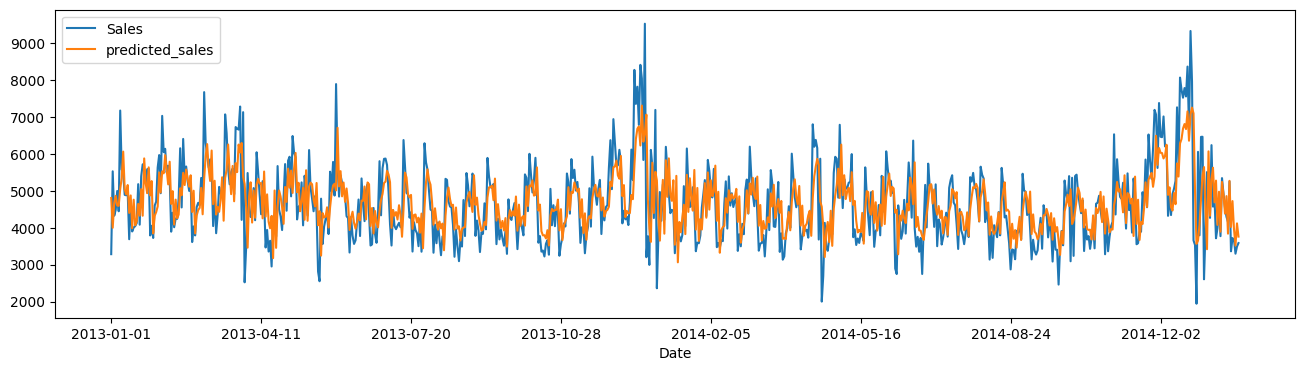

In [757]:
# Plot actual sales vs. predicted sales using train data
train_prediction_m = pd.concat([train.reset_index(), model_1_m.predict(start=0, end=len(train)-1).reset_index(drop=True)], axis=1)\
    .rename(columns={'predicted_mean':'predicted_sales'})
train_prediction_m.set_index('Date', inplace=True)
train_prediction_m[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

<AxesSubplot: xlabel='Date'>

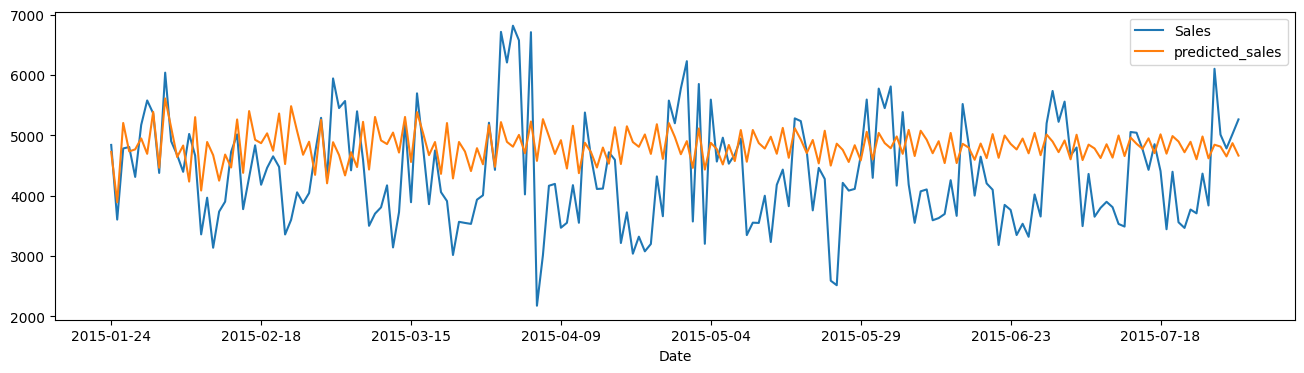

In [758]:
# Plot of actual sales vs. predicted sales in test data
# Predictions are not good, especially for data in the long term.
model_1_predictions_m = model_1_m.predict(start=len(train), end=len(data_store_1_processed)-1)
model_1_results_m = pd.concat([pd.DataFrame(test).reset_index(), pd.DataFrame(model_1_predictions_m).reset_index(drop=True)], axis=1)\
    .rename(columns={'predicted_mean':'predicted_sales'})
model_1_results_m.set_index('Date')[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [993]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(model_1_results_m['Sales'][:14], model_1_results_m['predicted_sales'][:14], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_1_results_m['Sales'][:14], model_1_results_m['predicted_sales'][:14])))
#print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((model_1_results_m['Sales'][:14] - model_1_results_m['predicted_sales'][:14]) / model_1_results_m['Sales'][:14])))))

RMSE: 412.05
MAPE: 6.57%


##### Test if applying first difference and seasonal difference improves performance
- Applying first difference and seasonal difference to the same model makes performance worse

In [761]:
sarima_model_1_diff = SARIMAX(train, order=(4, 1, 2), seasonal_order=(2, 1, 2, 21), trend='c')

In [762]:
model_1_diff = sarima_model_1_diff.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98894D+00    |proj g|=  2.01336D-01


 This problem is unconstrained.



At iterate    5    f=  7.93589D+00    |proj g|=  1.75608D-02

At iterate   10    f=  7.92474D+00    |proj g|=  1.89277D-02

At iterate   15    f=  7.91666D+00    |proj g|=  5.56403D-03

At iterate   20    f=  7.91576D+00    |proj g|=  4.27366D-03

At iterate   25    f=  7.91448D+00    |proj g|=  5.33772D-03

At iterate   30    f=  7.91437D+00    |proj g|=  8.35925D-04

At iterate   35    f=  7.91430D+00    |proj g|=  2.21667D-03

At iterate   40    f=  7.91409D+00    |proj g|=  2.38792D-03

At iterate   45    f=  7.91352D+00    |proj g|=  1.01543D-02

At iterate   50    f=  7.91042D+00    |proj g|=  8.51235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<AxesSubplot: xlabel='Date'>

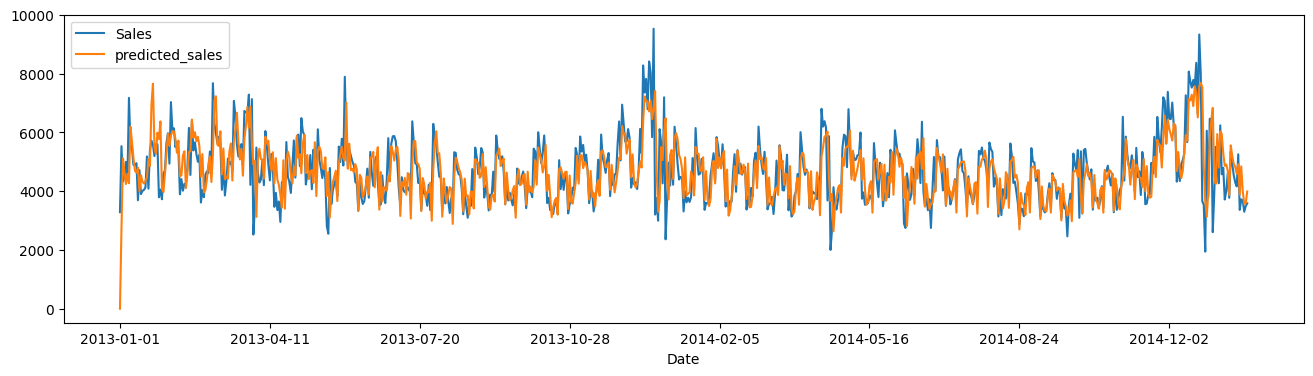

In [763]:
# Plot actual sales vs. predicted sales using train data
train_prediction_diff = pd.concat([train.reset_index(), model_1_diff.predict(start=0, end=len(train)-1).reset_index(drop=True)], axis=1)\
    .rename(columns={'predicted_mean':'predicted_sales'})
train_prediction_diff.set_index('Date', inplace=True)
train_prediction_diff[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

<AxesSubplot: xlabel='Date'>

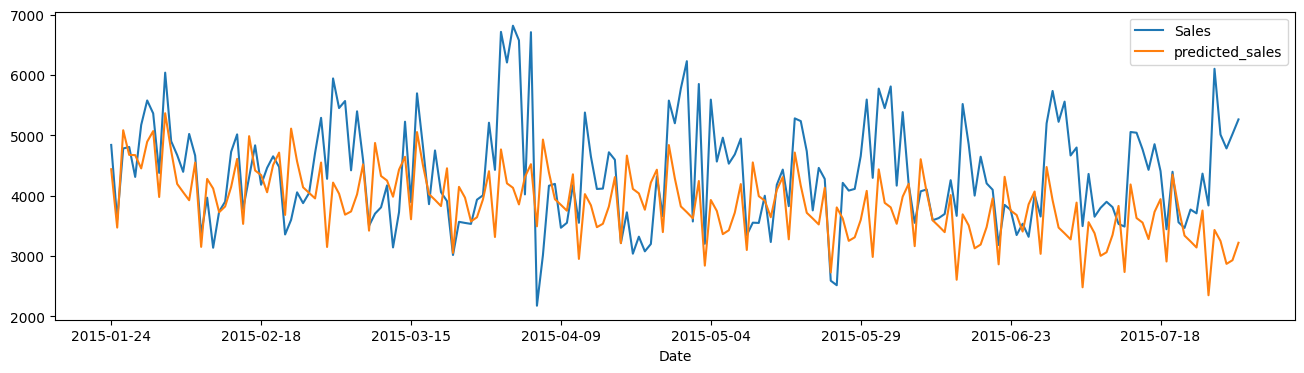

In [764]:
# Plot of actual sales vs. predicted sales in test data
# Predictions are not good, especially for data in the long term.
model_1_predictions_diff = model_1_diff.predict(start=len(train), end=len(data_store_1_processed)-1)
model_1_results_diff = pd.concat([pd.DataFrame(test).reset_index(), pd.DataFrame(model_1_predictions_diff).reset_index(drop=True)], axis=1)\
    .rename(columns={'predicted_mean':'predicted_sales'})
model_1_results_diff.set_index('Date')[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [765]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {}'.format(mean_squared_error(model_1_results_diff['Sales'][:14], model_1_results_diff['predicted_sales'][:14], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_1_results_diff['Sales'][:14], model_1_results_diff['predicted_sales'][:14])))

MSE: 512.6419106112779
MAPE: 8.89%


#### 2nd model: SARIMA with 0s removed

##### Model a

In [7]:
data_store_1_remove_0 = data_store_1[data_store_1['Sales']!=0]

<AxesSubplot: xlabel='Date'>

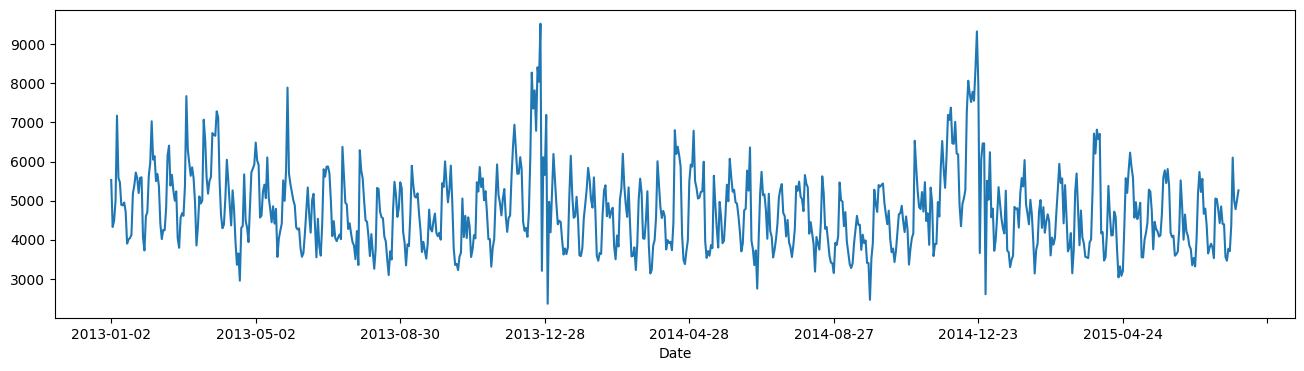

In [786]:
data_store_1_remove_0['Sales'].plot(figsize=[16, 4])

In [792]:
# Test if data is stationary with KPSS test
# p-value is 0.1, meaning data is stationary and doesn't need differencing
kpss(data_store_1_remove_0['Sales'])

(0.2868848628594494,
 0.1,
 13,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [840]:
data_store_1_remove_0.head()

,Sales
Date,
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
2013-01-07,7176


In [803]:
# Run auto seasonal ARIMA model to find appropriate parameter values
auto_arima(data_store_1_remove_0['Sales'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  781
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -6212.403
Date:                              Mon, 17 Jul 2023   AIC                          12442.807
Time:                                      20:49:53   BIC                          12484.752
Sample:                                           0   HQIC                         12458.939
                                              - 781                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1740.2472    501.144      3.473      0.001     758.023    2722.472
ar.L1         -0.9427      0.063    -15.072      0.000      -1.065      -0.820
ar.L2          0.3058      0.039      7.786      0.000       0.229       0.383
ar.L3          0.5031      0.051      9.879      0.000       0.403       0.603
ma.L1          1.6080      0.060     26.680      0.000       1.490       1.726
ma.L2          0.8350      0.053     15.719      0.000       0.731       0.939
ar.S.L12       0.6783      0.086      7.910      0.000       0.510       0.846
ma.S.L12      -0.4571      0.108     -4.227      0.000      -0.669      -0.245
sigma2      4.986e+05   1.94e+04     25.664      0.000    4.61e+05    5.37e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               540.88
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.13
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [851]:
# Split data into train and test sets
train_2_a = data_store_1_remove_0.iloc[:624, 0]
test_2_a = data_store_1_remove_0.iloc[624:, 0]

In [852]:
sarima_model_2_a = SARIMAX(train_2_a, order=(3, 0, 2), seasonal_order=(1, 0, 1, 12), trend='c')
model_2_a = sarima_model_2_a.fit()
model_2_a.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89848D+01    |proj g|=  1.88913D+02

At iterate    5    f=  9.29330D+00    |proj g|=  4.51155D-01

At iterate   10    f=  8.32399D+00    |proj g|=  2.59851D-01

At iterate   15    f=  8.02950D+00    |proj g|=  7.64908D-02

At iterate   20    f=  8.01164D+00    |proj g|=  2.06614D-02

At iterate   25    f=  8.00380D+00    |proj g|=  3.69284D-02

At iterate   30    f=  7.99628D+00    |proj g|=  1.42465D-02

At iterate   35    f=  7.99565D+00    |proj g|=  1.49584D-02

At iterate   40    f=  7.99366D+00    |proj g|=  9.26857D-03

At iterate   45    f=  7.99363D+00    |proj g|=  5.29706D-04

At iterate   50    f=  7.99362D+00    |proj g|=  8.91408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  624
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -4988.018
Date:                              Mon, 17 Jul 2023   AIC                           9994.036
Time:                                      21:09:34   BIC                          10033.961
Sample:                                           0   HQIC                         10009.550
                                              - 624                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1682.0959    602.121      2.794      0.005     501.961    2862.231
ar.L1         -0.8637      0.099     -8.738      0.000      -1.057      -0.670
ar.L2          0.3243      0.049      6.667      0.000       0.229       0.420
ar.L3          0.4480      0.076      5.924      0.000       0.300       0.596
ma.L1          1.5214      0.098     15.481      0.000       1.329       1.714
ma.L2          0.7680      0.085      9.027      0.000       0.601       0.935
ar.S.L12       0.6808      0.106      6.412      0.000       0.473       0.889
ma.S.L12      -0.4748      0.133     -3.560      0.000      -0.736      -0.213
sigma2      5.382e+05   2.37e+04     22.710      0.000    4.92e+05    5.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               447.31
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.13
Prob(H) (two-sided):                  0.12   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [853]:
model_2_a_predictions = model_2_a.predict(start=len(train_2_a), end=len(data_store_1_remove_0)-1)

In [854]:
model_2_a_results = pd.concat([pd.DataFrame(test_2_a).reset_index(), pd.DataFrame(model_2_a_predictions).reset_index(drop=True)], axis=1).set_index('Date')
model_2_a_results.rename(columns={'predicted_mean':'predicted_sales'}, inplace=True)

<AxesSubplot: xlabel='Date'>

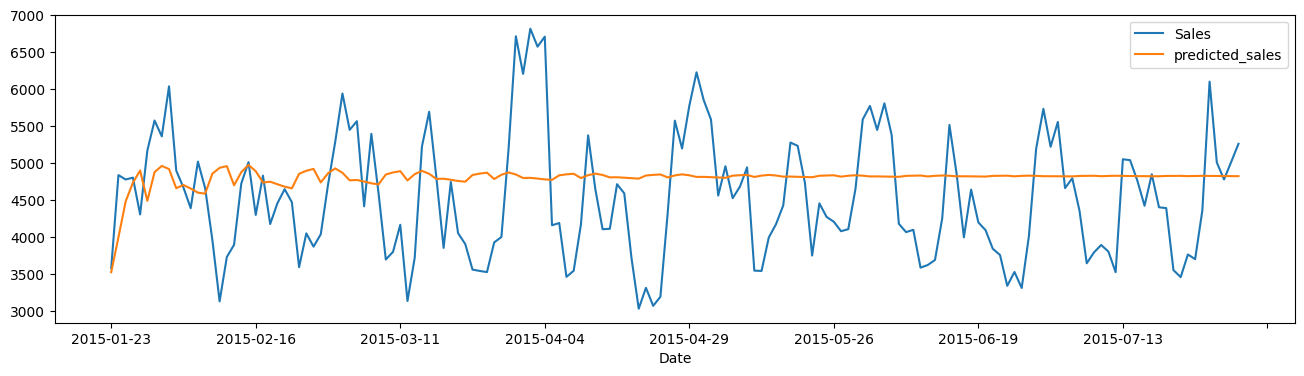

In [855]:
# Predictions are not good
model_2_a_results[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

##### Model b:
- Stabilize variance in sales with log transformation.
- Take a first difference of seasonally differenced sales.
- Predictions are bad. (Also tried to model sales without log transformation with first difference of seasonally differenced sales applied, but predictions are still bad)

In [819]:
data_store_1_remove_0_b = data_store_1_remove_0.copy()
data_store_1_remove_0_b['log_sales'] = np.log(data_store_1_remove_0_b['Sales'])

In [825]:
auto_arima(data_store_1_remove_0_b['log_sales'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  781
Model:             SARIMAX(2, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood                 393.432
Date:                                 Mon, 17 Jul 2023   AIC                           -772.864
Time:                                         20:56:57   BIC                           -740.240
Sample:                                              0   HQIC                          -760.317
                                                 - 781                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.1000      0.446     11.429      0.000       4.225       5.975
ar.L1         -0.2214      0.054     -4.135      0.000      -0.326      -0.116
ar.L2          0.6181      0.031     19.678      0.000       0.557       0.680
ma.L1          0.8044      0.057     14.119      0.000       0.693       0.916
ma.S.L12       0.1946      0.033      5.858      0.000       0.129       0.260
ma.S.L24       0.1387      0.034      4.074      0.000       0.072       0.205
sigma2         0.0212      0.001     25.777      0.000       0.020       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):               605.47
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [503]:
# m is set to 6 because there are 6 days in a week. Store is closed one day per week.
auto_arima(data_store_1_remove_0_b['log_sales'], seasonal=True, m=6, d=1, D=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  781
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 6)   Log Likelihood                 295.612
Date:                             Sun, 16 Jul 2023   AIC                           -581.225
Time:                                     15:04:27   BIC                           -557.967
Sample:                                          0   HQIC                          -572.276
                                             - 781                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3746      0.029    -13.023      0.000      -0.431      -0.318
ma.L2         -0.1605      0.034     -4.749      0.000      -0.227      -0.094
ar.S.L6       -0.2490      0.032     -7.765      0.000      -0.312      -0.186
ma.S.L6       -0.9263      0.015    -61.807      0.000      -0.956      -0.897
sigma2         0.0268      0.001     34.292      0.000       0.025       0.028
===================================================================================
Ljung-Box (L1) (Q):                   1.93   Jarque-Bera (JB):               936.48
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [465]:
# Split data into train and test sets
train_2_b = data_store_1_remove_0_b.iloc[:624, 1]
test_2_b = data_store_1_remove_0_b.iloc[624:, 0]

In [830]:
sarima_model_2_b = SARIMAX(train_2_b, order=(2, 0, 1), seasonal_order=(0, 0, 2, 12))
model_2_b = sarima_model_2_b.fit()
model_2_b.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.51581D-01    |proj g|=  2.16303D-01

At iterate    5    f= -3.84148D-01    |proj g|=  1.20650D-02

At iterate   10    f= -3.85950D-01    |proj g|=  5.40559D-02

At iterate   15    f= -4.01442D-01    |proj g|=  7.04447D-02

At iterate   20    f= -4.04563D-01    |proj g|=  7.49973D-04

At iterate   25    f= -4.04592D-01    |proj g|=  4.35627D-02

At iterate   30    f= -4.08166D-01    |proj g|=  4.82531D-01

At iterate   35    f= -4.20768D-01    |proj g|=  4.53275D-02

At iterate   40    f= -4.27872D-01    |proj g|=  4.57058D-01

At iterate   45    f= -4.38829D-01    |proj g|=  1.76735D-02

At iterate   50    f= -4.40302D-01    |proj g|=  4.99576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                               log_sales   No. Observations:                  624
Model:             SARIMAX(2, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood                 274.748
Date:                                 Mon, 17 Jul 2023   AIC                           -537.497
Time:                                         20:58:14   BIC                           -510.880
Sample:                                              0   HQIC                          -527.154
                                                 - 624                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6097      0.029     56.406      0.000       1.554       1.666
ar.L2         -0.6097      0.029    -21.366      0.000      -0.666      -0.554
ma.L1         -0.9841      0.008   -130.586      0.000      -0.999      -0.969
ma.S.L12       0.1914      0.043      4.480      0.000       0.108       0.275
ma.S.L24       0.1474      0.046      3.230      0.001       0.058       0.237
sigma2         0.0238      0.001     24.831      0.000       0.022       0.026
===================================================================================
Ljung-Box (L1) (Q):                   2.14   Jarque-Bera (JB):              1048.88
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [856]:
sarima_model_2_b = SARIMAX(train_2_b, order=(2, 0, 1), seasonal_order=(0, 0, 2, 12))
model_2_b = sarima_model_2_b.fit()
model_2_b.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.51581D-01    |proj g|=  2.16303D-01


 This problem is unconstrained.



At iterate    5    f= -3.84148D-01    |proj g|=  1.20650D-02

At iterate   10    f= -3.85950D-01    |proj g|=  5.40559D-02

At iterate   15    f= -4.01442D-01    |proj g|=  7.04447D-02

At iterate   20    f= -4.04563D-01    |proj g|=  7.49973D-04

At iterate   25    f= -4.04592D-01    |proj g|=  4.35627D-02

At iterate   30    f= -4.08166D-01    |proj g|=  4.82531D-01

At iterate   35    f= -4.20768D-01    |proj g|=  4.53275D-02

At iterate   40    f= -4.27872D-01    |proj g|=  4.57058D-01

At iterate   45    f= -4.38829D-01    |proj g|=  1.76735D-02

At iterate   50    f= -4.40302D-01    |proj g|=  4.99576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                               log_sales   No. Observations:                  624
Model:             SARIMAX(2, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood                 274.748
Date:                                 Mon, 17 Jul 2023   AIC                           -537.497
Time:                                         21:10:38   BIC                           -510.880
Sample:                                              0   HQIC                          -527.154
                                                 - 624                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6097      0.029     56.406      0.000       1.554       1.666
ar.L2         -0.6097      0.029    -21.366      0.000      -0.666      -0.554
ma.L1         -0.9841      0.008   -130.586      0.000      -0.999      -0.969
ma.S.L12       0.1914      0.043      4.480      0.000       0.108       0.275
ma.S.L24       0.1474      0.046      3.230      0.001       0.058       0.237
sigma2         0.0238      0.001     24.831      0.000       0.022       0.026
===================================================================================
Ljung-Box (L1) (Q):                   2.14   Jarque-Bera (JB):              1048.88
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [857]:
model_2_b_predictions = model_2_b.predict(start=len(train_2_b), end=len(data_store_1_remove_0_b)-1)

In [858]:
model_2_b_results = pd.concat([pd.DataFrame(test_2_b).reset_index(), pd.DataFrame(np.exp(model_2_b_predictions)).reset_index(drop=True)], axis=1).set_index('Date')
model_2_b_results.rename(columns={'predicted_mean':'predicted_sales'}, inplace=True)

<AxesSubplot: xlabel='Date'>

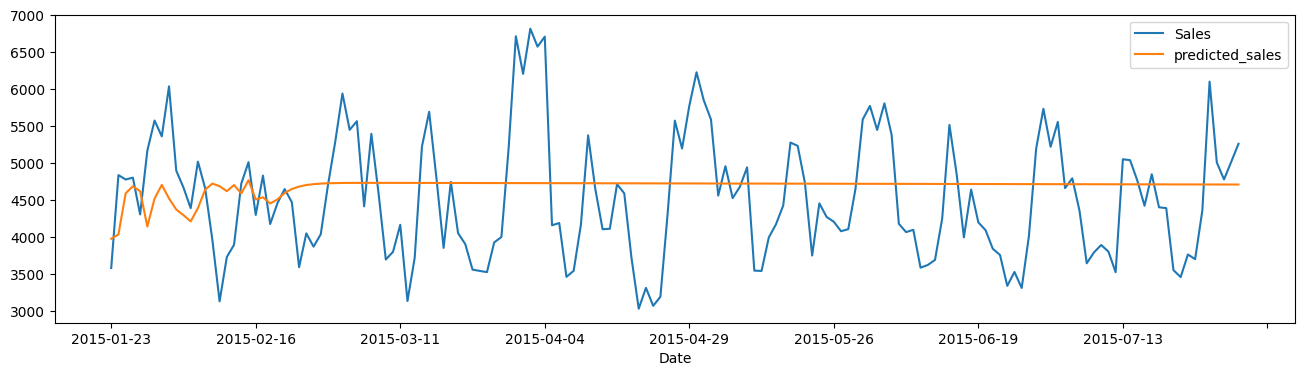

In [859]:
model_2_b_results[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

#### 3rd model: SARIMAX model
- Seasonal ARIMA model with exogenous variables

##### 1st SARIMAX model
- Remove days when store was closed
- m is set to 6
- Compared to SARIMA model, SARIMAX makes much better predictions, especially in the long term.

In [536]:
data_store_1_sarimax = data[data['Store']==1].loc[:, ['DayOfWeek', 'Date', 'Open', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday']].set_index('Date')
data_store_1_sarimax = data_store_1_sarimax[data_store_1_sarimax['Open']==1]
data_store_1_sarimax.drop(columns='Open', inplace=True)
data_store_1_sarimax.sort_index(inplace=True)

In [537]:
# One-hot encode day of week
data_store_1_sarimax = data_store_1_sarimax.merge(pd.get_dummies(data_store_1_sarimax['DayOfWeek'], prefix='dayofweek'), on='Date').drop(columns='DayOfWeek')
data_store_1_sarimax.head()

,Sales,Promo,StateHoliday,SchoolHoliday,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
Date,,,,,,,,,,
2013-01-02,5530,0,0,1,0,0,1,0,0,0
2013-01-03,4327,0,0,1,0,0,0,1,0,0
2013-01-04,4486,0,0,1,0,0,0,0,1,0
2013-01-05,4997,0,0,1,0,0,0,0,0,1
2013-01-07,7176,1,0,1,1,0,0,0,0,0


In [538]:
data_store_1_sarimax['StateHoliday'] = data_store_1_sarimax['StateHoliday'].astype(np.int64)

In [980]:
auto_arima(data_store_1_sarimax['Sales'], exogenous=data_store_1_sarimax.iloc[:, 1:], seasonal=True, m=6).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  781
Model:             SARIMAX(3, 0, 3)x(2, 0, [1, 2], 6)   Log Likelihood               -6207.657
Date:                                Mon, 17 Jul 2023   AIC                          12439.315
Time:                                        22:30:53   BIC                          12495.242
Sample:                                             0   HQIC                         12460.824
                                                - 781                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1692.6431   1245.654      1.359      0.174    -748.793    4134.079
ar.L1         -0.8359      0.098     -8.564      0.000      -1.027      -0.645
ar.L2          0.4054      0.056      7.191      0.000       0.295       0.516
ar.L3          0.5275      0.054      9.730      0.000       0.421       0.634
ma.L1          1.4822      0.105     14.065      0.000       1.276       1.689
ma.L2          0.6359      0.133      4.790      0.000       0.376       0.896
ma.L3         -0.1239      0.069     -1.790      0.073      -0.260       0.012
ar.S.L6       -0.0951      0.144     -0.661      0.508      -0.377       0.187
ar.S.L12       0.7012      0.135      5.208      0.000       0.437       0.965
ma.S.L6       -0.0004      0.162     -0.002      0.998      -0.319       0.318
ma.S.L12      -0.4909      0.143     -3.442      0.001      -0.770      -0.211
sigma2      5.125e+05   2.08e+04     24.665      0.000    4.72e+05    5.53e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               510.93
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.05
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [539]:
# Split data into train and test sets
train_3 = data_store_1_sarimax.iloc[:624]
test_3 = data_store_1_sarimax.iloc[624:]

In [540]:
sarimax_model = SARIMAX(train_3['Sales'], exog=train_3.iloc[:, 1:], order=(3, 0, 3), seasonal_order=(2, 0, 2, 6), enforce_stationarity=False, initialization='approximate_diffuse').fit(disp=False)
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Sales   No. Observations:                  624
Model:             SARIMAX(3, 0, 3)x(2, 0, [1, 2], 6)   Log Likelihood               -4877.287
Date:                                Thu, 20 Jul 2023   AIC                           9794.574
Time:                                        20:59:32   BIC                           9883.297
Sample:                                             0   HQIC                          9829.051
                                                - 624                                         
Covariance Type:                                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo          1258.8878     83.286     15.115      0.000    1095.651    1422.124
StateHoliday  -2.724e-12      0.000  -7.57e-09      1.000      -0.001       0.001
SchoolHoliday   -65.7219    102.517     -0.641      0.521    -266.652     135.209
dayofweek_1    4572.3652    184.768     24.747      0.000    4210.227    4934.503
dayofweek_2    4080.1957    191.047     21.357      0.000    3705.751    4454.640
dayofweek_3    3941.8597    191.059     20.632      0.000    3567.391    4316.329
dayofweek_4    3816.4890    193.407     19.733      0.000    3437.419    4195.559
dayofweek_5    4170.8102    180.724     23.078      0.000    3816.597    4525.024
dayofweek_6    5013.8841    168.374     29.778      0.000    4683.878    5343.891
ar.L1            -0.1875      0.197     -0.952      0.341      -0.573       0.198
ar.L2             0.6357      0.074      8.547      0.000       0.490       0.781
ar.L3             0.3235      0.149      2.173      0.030       0.032       0.615
ma.L1             0.6777      0.192      3.530      0.000       0.301       1.054
ma.L2            -0.1144      0.130     -0.878      0.380      -0.370       0.141
ma.L3            -0.3564      0.061     -5.797      0.000      -0.477      -0.236
ar.S.L6          -0.1562      0.273     -0.572      0.567      -0.691       0.379
ar.S.L12          0.7023      0.255      2.755      0.006       0.203       1.202
ma.S.L6           0.1380      0.284      0.487      0.627      -0.418       0.694
ma.S.L12         -0.6527      0.260     -2.515      0.012      -1.161      -0.144
sigma2          3.58e+05   1.62e+04     22.114      0.000    3.26e+05     3.9e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               950.65
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -0.29
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.49e+21. Standard errors may be unstable.
"""

In [541]:
model_3_predictions = sarimax_model.predict(start=len(train_3), end=len(data_store_1_sarimax)-1, exog=test_3.iloc[:, 1:])

In [542]:
model_3_results = pd.concat([pd.DataFrame(test_3['Sales']).reset_index(), pd.DataFrame(model_3_predictions).reset_index(drop=True)], axis=1).set_index('Date')
model_3_results.rename(columns={'predicted_mean':'predicted_sales'}, inplace=True)

<AxesSubplot: xlabel='Date'>

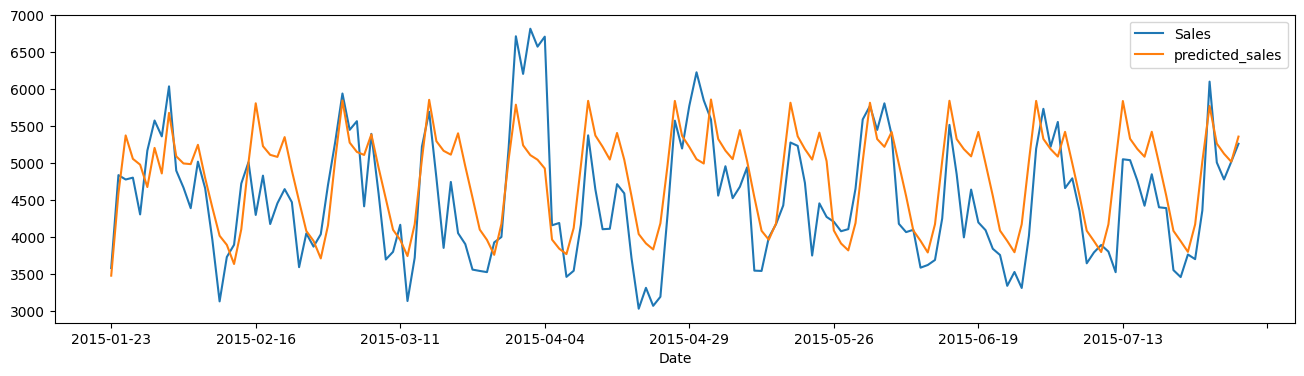

In [241]:
model_3_results[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [242]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(model_3_results['Sales'][:12], model_3_results['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_3_results['Sales'][:12], model_3_results['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((model_3_results['Sales'][:12] - model_3_results['predicted_sales'][:12]) / model_3_results['Sales'][:12])))))

RMSE: 427.55
MAPE: 8.09%
RMSPE: 8.96%


In [243]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(model_3_results['Sales'][:36], model_3_results['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_3_results['Sales'][:36], model_3_results['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((model_3_results['Sales'][:36] - model_3_results['predicted_sales'][:36]) / model_3_results['Sales'][:36])))))

RMSE: 527.94
MAPE: 9.77%
RMSPE: 12.48%


In [543]:
print('RMSE: {:.2f}'.format(mean_squared_error(model_3_results['Sales'], model_3_results['predicted_sales'], squared=False)))

RMSE: 638.70


#### 2nd SARIMAX model
- m is set to 12
- Model performs slightly worse than the 1st SARIMAX model

In [998]:
auto_arima(data_store_1_sarimax['Sales'], exogenous=data_store_1_sarimax.iloc[:, 1:], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  781
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -6212.403
Date:                              Mon, 17 Jul 2023   AIC                          12442.807
Time:                                      22:43:38   BIC                          12484.752
Sample:                                           0   HQIC                         12458.939
                                              - 781                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1740.2472    501.144      3.473      0.001     758.023    2722.472
ar.L1         -0.9427      0.063    -15.072      0.000      -1.065      -0.820
ar.L2          0.3058      0.039      7.786      0.000       0.229       0.383
ar.L3          0.5031      0.051      9.879      0.000       0.403       0.603
ma.L1          1.6080      0.060     26.680      0.000       1.490       1.726
ma.L2          0.8350      0.053     15.719      0.000       0.731       0.939
ar.S.L12       0.6783      0.086      7.910      0.000       0.510       0.846
ma.S.L12      -0.4571      0.108     -4.227      0.000      -0.669      -0.245
sigma2      4.986e+05   1.94e+04     25.664      0.000    4.61e+05    5.37e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               540.88
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.13
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [999]:
sarimax_model_2 = SARIMAX(train_3['Sales'], exog=train_3.iloc[:, 1:], order=(3, 0, 2), seasonal_order=(1, 0, 1, 12)).fit()
sarimax_model_2.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25063D+00    |proj g|=  1.15441D+00

At iterate    5    f=  7.85399D+00    |proj g|=  9.64139D-02

At iterate   10    f=  7.82753D+00    |proj g|=  4.81059D-02

At iterate   15    f=  7.82222D+00    |proj g|=  4.22827D-03

At iterate   20    f=  7.81999D+00    |proj g|=  1.06023D-02

At iterate   25    f=  7.81973D+00    |proj g|=  4.64458D-04

At iterate   30    f=  7.81971D+00    |proj g|=  1.47616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  624
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -4879.501
Date:                              Mon, 17 Jul 2023   AIC                           9793.003
Time:                                      22:44:34   BIC                           9868.417
Sample:                                           0   HQIC                          9822.308
                                              - 624                                         
Covariance Type:                                opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo          1258.8831     79.967     15.743      0.000    1102.151    1415.615
StateHoliday  -2.724e-12     59.247   -4.6e-14      1.000    -116.123     116.123
SchoolHoliday   -65.7230    102.343     -0.642      0.521    -266.312     134.866
dayofweek_1    4572.3633    190.796     23.965      0.000    4198.411    4946.316
dayofweek_2    4080.1889    197.910     20.616      0.000    3692.292    4468.085
dayofweek_3    3941.8715    196.384     20.072      0.000    3556.966    4326.777
dayofweek_4    3816.4799    200.753     19.011      0.000    3423.011    4209.949
dayofweek_5    4170.8012    186.724     22.337      0.000    3804.830    4536.773
dayofweek_6    5013.8990    175.261     28.608      0.000    4670.394    5357.404
ar.L1             0.3268      0.221      1.481      0.139      -0.106       0.759
ar.L2             0.7465      0.091      8.167      0.000       0.567       0.926
ar.L3            -0.2147      0.123     -1.743      0.081      -0.456       0.027
ma.L1             0.1176      0.212      0.554      0.579      -0.298       0.533
ma.L2            -0.4350      0.102     -4.279      0.000      -0.634      -0.236
ar.S.L12          0.7717      0.209      3.700      0.000       0.363       1.180
ma.S.L12         -0.7051      0.233     -3.029      0.002      -1.161      -0.249
sigma2         3.614e+05   1.47e+04     24.558      0.000    3.33e+05     3.9e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              1070.69
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.38
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.43e+19. Standard errors may be unstable.
"""

In [1000]:
model_3_predictions_2nd = sarimax_model_2.predict(start=len(train_3), end=len(data_store_1_sarimax)-1, exog=test_3.iloc[:, 1:])

In [1001]:
model_3_results_2nd = pd.concat([pd.DataFrame(test_3['Sales']).reset_index(), pd.DataFrame(model_3_predictions_2nd).reset_index(drop=True)], axis=1).set_index('Date')
model_3_results_2nd.rename(columns={'predicted_mean':'predicted_sales'}, inplace=True)

<AxesSubplot: xlabel='Date'>

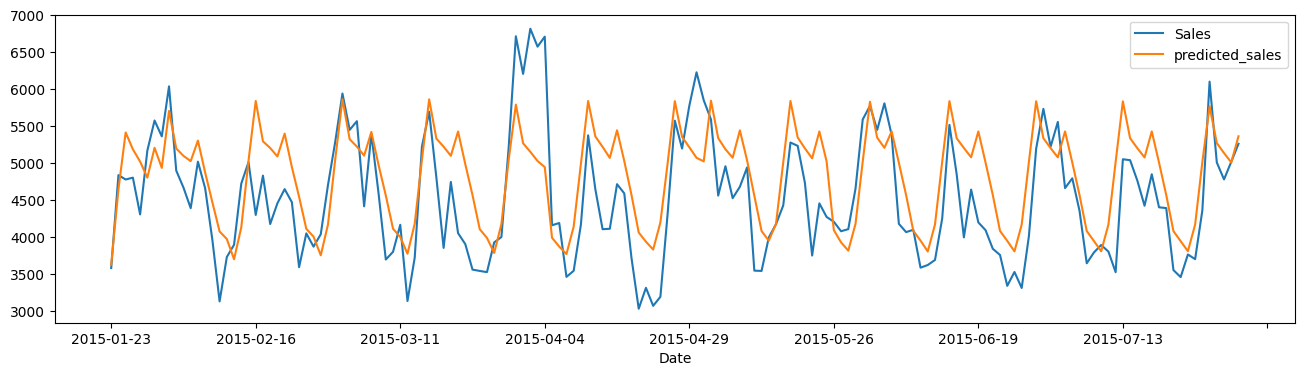

In [1002]:
model_3_results_2nd[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [1003]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(model_3_results_2nd['Sales'][:12], model_3_results_2nd['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_3_results_2nd['Sales'][:12], model_3_results_2nd['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((model_3_results_2nd['Sales'][:12] - model_3_results_2nd['predicted_sales'][:12]) / model_3_results_2nd['Sales'][:12])))))

RMSE: 440.81
MAPE: 8.32%
RMSPE: 9.34%


In [1004]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(model_3_results_2nd['Sales'][:36], model_3_results_2nd['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_3_results_2nd['Sales'][:36], model_3_results_2nd['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((model_3_results_2nd['Sales'][:36] - model_3_results_2nd['predicted_sales'][:36]) / model_3_results_2nd['Sales'][:36])))))

RMSE: 548.30
MAPE: 10.21%
RMSPE: 13.05%


#### 3rd SARIMAX model
- m is set to 18 
- Model performs slightly worse than the 1st model but slightly better than the 2nd model.

In [1005]:
auto_arima(data_store_1_sarimax['Sales'], exogenous=data_store_1_sarimax.iloc[:, 1:], seasonal=True, m=18).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  781
Model:             SARIMAX(5, 0, 1)x(2, 0, [], 18)   Log Likelihood               -6230.925
Date:                             Mon, 17 Jul 2023   AIC                          12481.850
Time:                                     22:54:40   BIC                          12528.456
Sample:                                          0   HQIC                         12499.774
                                             - 781                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1839.1638    255.500      7.198      0.000    1338.393    2339.935
ar.L1          0.5264      0.143      3.684      0.000       0.246       0.806
ar.L2          0.1744      0.097      1.792      0.073      -0.016       0.365
ar.L3         -0.1495      0.042     -3.560      0.000      -0.232      -0.067
ar.L4          0.2330      0.040      5.899      0.000       0.156       0.310
ar.L5         -0.2040      0.035     -5.783      0.000      -0.273      -0.135
ma.L1          0.1796      0.147      1.219      0.223      -0.109       0.468
ar.S.L18      -0.0144      0.036     -0.397      0.692      -0.085       0.057
ar.S.L36       0.0932      0.036      2.614      0.009       0.023       0.163
sigma2      4.986e+05   1.85e+04     26.899      0.000    4.62e+05    5.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               354.20
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.26
Prob(H) (two-sided):                  0.13   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1006]:
sarimax_model_3 = SARIMAX(train_3['Sales'], exog=train_3.iloc[:, 1:], order=(5, 0, 1), seasonal_order=(2, 0, 0, 18)).fit()
sarimax_model_3.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82086D+00    |proj g|=  1.43739D-01

At iterate    5    f=  7.80877D+00    |proj g|=  9.77507D-04

At iterate   10    f=  7.80876D+00    |proj g|=  1.28830D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     14     16      1     0     0   3.372D-05   7.809D+00
  F =   7.8087591598848345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                  624
Model:             SARIMAX(5, 0, 1)x(2, 0, [], 18)   Log Likelihood               -4872.666
Date:                             Mon, 17 Jul 2023   AIC                           9781.331
Time:                                     22:55:20   BIC                           9861.182
Sample:                                          0   HQIC                          9812.361
                                             - 624                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo          1258.8865     71.340     17.646      0.000    1119.062    1398.711
StateHoliday  -2.724e-12   2.42e+05  -1.12e-17      1.000   -4.75e+05    4.75e+05
SchoolHoliday   -65.7249     99.838     -0.658      0.510    -261.404     129.954
dayofweek_1    4572.3561    154.435     29.607      0.000    4269.669    4875.043
dayofweek_2    4080.1949    162.922     25.044      0.000    3760.873    4399.517
dayofweek_3    3941.8766    159.721     24.680      0.000    3628.829    4254.925
dayofweek_4    3816.4756    162.716     23.455      0.000    3497.559    4135.393
dayofweek_5    4170.8005    149.960     27.813      0.000    3876.884    4464.717
dayofweek_6    5013.8999    139.793     35.867      0.000    4739.911    5287.889
ar.L1             0.2689      0.265      1.016      0.310      -0.250       0.788
ar.L2             0.2861      0.122      2.337      0.019       0.046       0.526
ar.L3            -0.0091      0.070     -0.130      0.896      -0.146       0.128
ar.L4             0.2805      0.038      7.400      0.000       0.206       0.355
ar.L5            -0.0762      0.068     -1.124      0.261      -0.209       0.057
ma.L1             0.2085      0.268      0.778      0.436      -0.317       0.733
ar.S.L18         -0.0315      0.047     -0.665      0.506      -0.124       0.061
ar.S.L36          0.0161      0.050      0.321      0.748      -0.082       0.114
sigma2          3.54e+05   1.51e+04     23.404      0.000    3.24e+05    3.84e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               656.21
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.14
Prob(H) (two-sided):                  0.15   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.68e+14. Standard errors may be unstable.
"""

In [1007]:
model_3_predictions_3rd = sarimax_model_3.predict(start=len(train_3), end=len(data_store_1_sarimax)-1, exog=test_3.iloc[:, 1:])

In [1008]:
model_3_results_3rd = pd.concat([pd.DataFrame(test_3['Sales']).reset_index(), pd.DataFrame(model_3_predictions_3rd).reset_index(drop=True)], axis=1).set_index('Date')
model_3_results_3rd.rename(columns={'predicted_mean':'predicted_sales'}, inplace=True)

<AxesSubplot: xlabel='Date'>

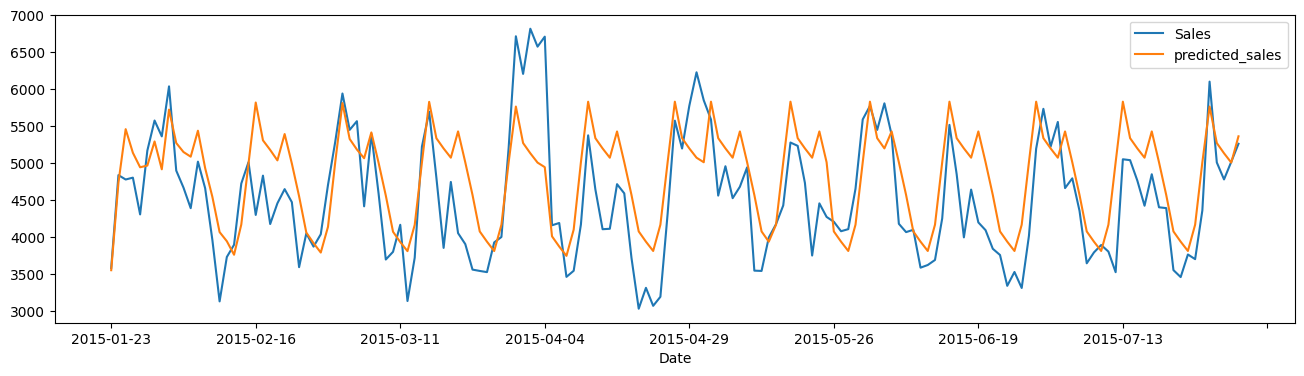

In [1009]:
model_3_results_3rd[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [1010]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(model_3_results_3rd['Sales'][:12], model_3_results_3rd['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_3_results_3rd['Sales'][:12], model_3_results_3rd['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((model_3_results_3rd['Sales'][:12] - model_3_results_3rd['predicted_sales'][:12]) / model_3_results_3rd['Sales'][:12])))))

RMSE: 433.89
MAPE: 7.92%
RMSPE: 9.24%


In [1011]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(model_3_results_3rd['Sales'][:36], model_3_results_3rd['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(model_3_results_3rd['Sales'][:36], model_3_results_3rd['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((model_3_results_3rd['Sales'][:36] - model_3_results_3rd['predicted_sales'][:36]) / model_3_results_3rd['Sales'][:36])))))

RMSE: 546.51
MAPE: 10.06%
RMSPE: 12.99%


### ETS models
- ETS models have worse performance than ARIMA models. This is probably because the data don't observe obvious trend, even though it observes some seasonality.

#### 1st model: Simple exponential smoothing
- Performance is not good. Forecasts will be the same regardless of forecast horizon.

In [266]:
data_ses = data_store_1_remove_0.copy()

In [267]:
data_ses.index.freq = 'D'

In [268]:
# Simple moving average of sales
# window is inclusive. For example, window of 2 will only include the last observation besides the current observation.
data_ses['3-week-SMA'] = data_ses['Sales'].rolling(window=18).mean()

In [269]:
# Exponentially weighted moving average
# ewm() calculates exponentially weighted moving averages
# span can be interpreted as "n-period exponentially weighted moving average"
# half-life is the period of time for the exponential weight to reduce to one half
# alpha = 2/(span+1), meaning a lower span causes calculated ewma to be closer to current observation
# Setting adjust to True or False will use different functions to calculate ewma
data_ses['3-week-EWMA'] = data_ses['Sales'].ewm(span=18, adjust=False).mean()

<AxesSubplot: xlabel='Date'>

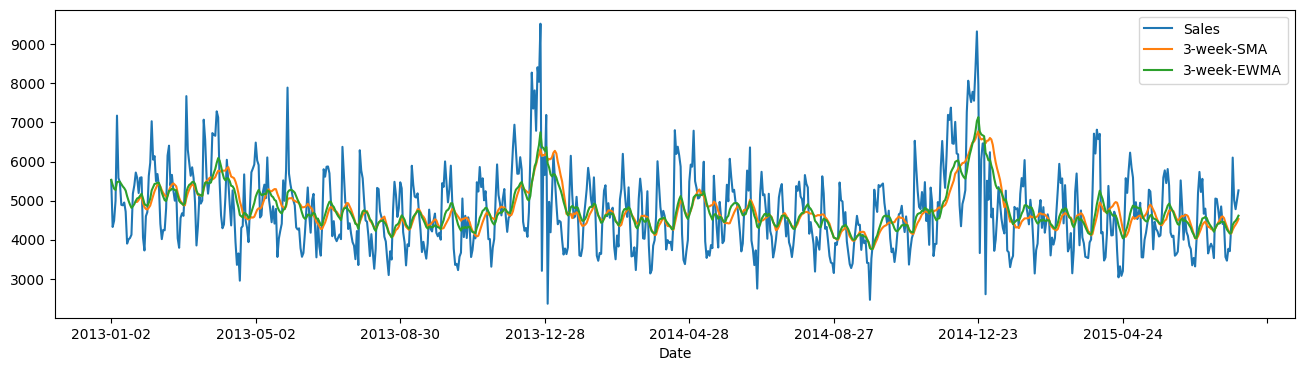

In [270]:
data_ses.plot(figsize=[16, 4])

In [271]:
# Setting span to 18 to consider sales during the last 18 days (3 weeks since store is closed one day per week)
span = 18
alpha = 2/(span+1)
ses_model = SimpleExpSmoothing(data_store_1_remove_0['Sales']).fit(smoothing_level=alpha, optimized=False)

In [272]:
# Need to apply shift(-1) when setting optimized to False in SimpleExpSmoothing because the first row gets repeated 
data_ses['3-week-SES'] = ses_model.fittedvalues.shift(-1)

In [273]:
# statsmodels Simple exponential smoothing returns the same results as ewm() method in pandas
data_ses.head()

,Sales,3-week-SMA,3-week-EWMA,3-week-SES
Date,,,,
2013-01-02,5530,NaN,5530.000000,5530.000000
2013-01-03,4327,NaN,5403.368421,5403.368421
2013-01-04,4486,NaN,5306.803324,5306.803324
2013-01-05,4997,NaN,5274.192448,5274.192448
2013-01-07,7176,NaN,5474.382717,5474.382717


In [274]:
# Split data into train and test sets to check how well SES performs
data_ses_train = data_ses.iloc[:624, 0]
data_ses_test = data_ses.iloc[624:, 0]

In [275]:
ses_model = SimpleExpSmoothing(data_ses_train).fit(smoothing_level=alpha, optimized=False)

In [276]:
ses_model_predictions = pd.concat([data_ses_test.reset_index(), \
    ses_model.forecast(len(data_ses_test)).reset_index().rename(columns={0:'predicted_sales'}).drop(columns='index')], axis=1)

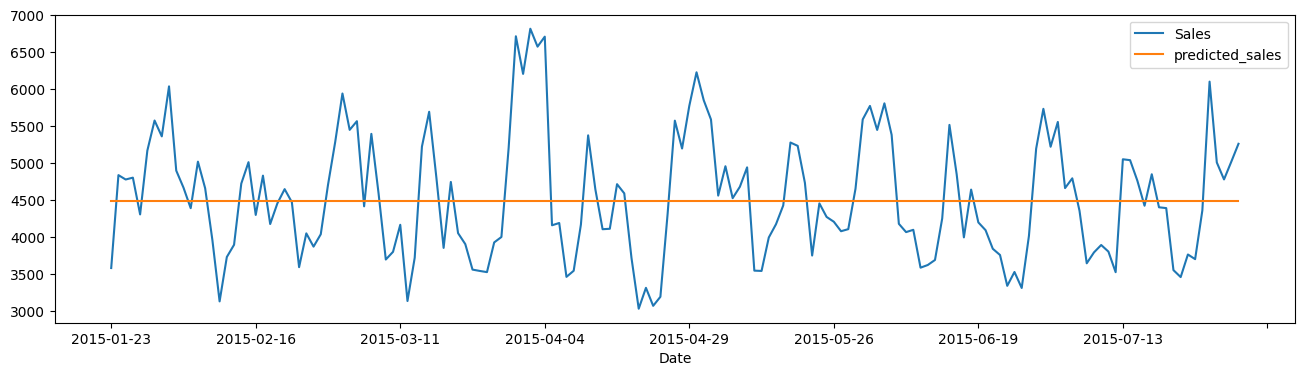

In [277]:
ses_model_predictions.set_index('Date')[['Sales', 'predicted_sales']].plot(figsize=[16, 4])
plt.show()

#### 2nd model: ETS model with additive seasonality, no trend
- Poor performance

In [291]:
# HW stands for Holt Winter
data_ses['HW_add_seasonal_18'] = ExponentialSmoothing(data_ses[['Sales']], seasonal='add', seasonal_periods=18).fit().fittedvalues.shift(-1)

<AxesSubplot: xlabel='Date'>

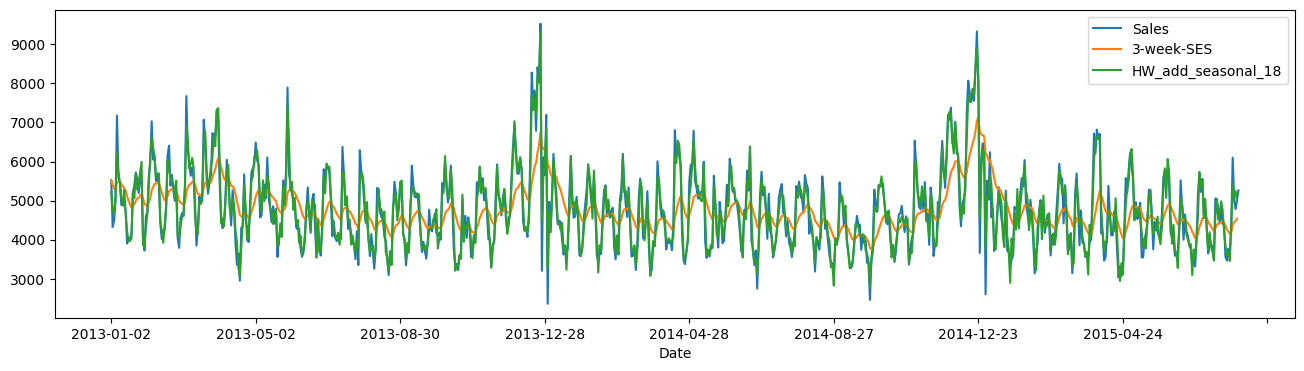

In [292]:
# Holt Winter's method with additive seasonality seems to fit data better
data_ses[['Sales', '3-week-SES', 'HW_add_seasonal_18']].plot(figsize=[16, 4])

In [294]:
# Split data into train and test sets to check how well additive seasonality performs
data_hw_train = data_ses.iloc[:624, [0]]
data_hw_test = data_ses.iloc[624:, [0]]

In [296]:
# Setting seasonal_periods to 18 results in highest accuracy
for i in range(2, 50):
    hw_add_season_model = ExponentialSmoothing(data_hw_train, seasonal='add', seasonal_periods=i).fit()
    hw_add_season_predictions = pd.concat([data_hw_test.reset_index(), \
        hw_add_season_model.predict(start=len(data_hw_train), end=len(data_ses)-1).reset_index().rename(columns={0:'predicted_sales'}).drop(columns='index')], axis=1)
    print(i, 'MAPE: {:.2%}'.format(mean_absolute_percentage_error(hw_add_season_predictions['Sales'], hw_add_season_predictions['predicted_sales'])))

2 MAPE: 20.61%
3 MAPE: 21.88%
4 MAPE: 23.69%
5 MAPE: 24.76%
6 MAPE: 21.08%
7 MAPE: 21.63%
8 MAPE: 22.52%
9 MAPE: 18.78%
10 MAPE: 25.46%
11 MAPE: 17.64%
12 MAPE: 21.88%
13 MAPE: 29.38%
14 MAPE: 18.79%
15 MAPE: 22.35%
16 MAPE: 18.76%
17 MAPE: 20.20%
18 MAPE: 15.89%
19 MAPE: 20.81%
20 MAPE: 21.39%
21 MAPE: 23.99%
22 MAPE: 18.54%
23 MAPE: 23.25%
24 MAPE: 22.36%
25 MAPE: 22.83%
26 MAPE: 21.68%
27 MAPE: 22.01%
28 MAPE: 17.53%
29 MAPE: 26.78%
30 MAPE: 23.43%
31 MAPE: 22.06%
32 MAPE: 18.12%
33 MAPE: 23.34%
34 MAPE: 17.58%
35 MAPE: 18.06%
36 MAPE: 19.15%
37 MAPE: 26.64%
38 MAPE: 17.44%
39 MAPE: 17.08%
40 MAPE: 18.93%
41 MAPE: 16.38%
42 MAPE: 22.90%
43 MAPE: 30.04%
44 MAPE: 17.23%
45 MAPE: 20.60%
46 MAPE: 28.78%
47 MAPE: 24.86%
48 MAPE: 19.59%
49 MAPE: 23.25%


In [299]:
# Fit the HW model
hw_add_season_model = ExponentialSmoothing(data_hw_train, seasonal='add', seasonal_periods=18).fit()
hw_add_season_predictions = pd.concat([data_hw_test.reset_index(), \
    hw_add_season_model.predict(start=len(data_hw_train), end=len(data_ses)-1).reset_index().rename(columns={0:'predicted_sales'}).drop(columns='index')], axis=1)

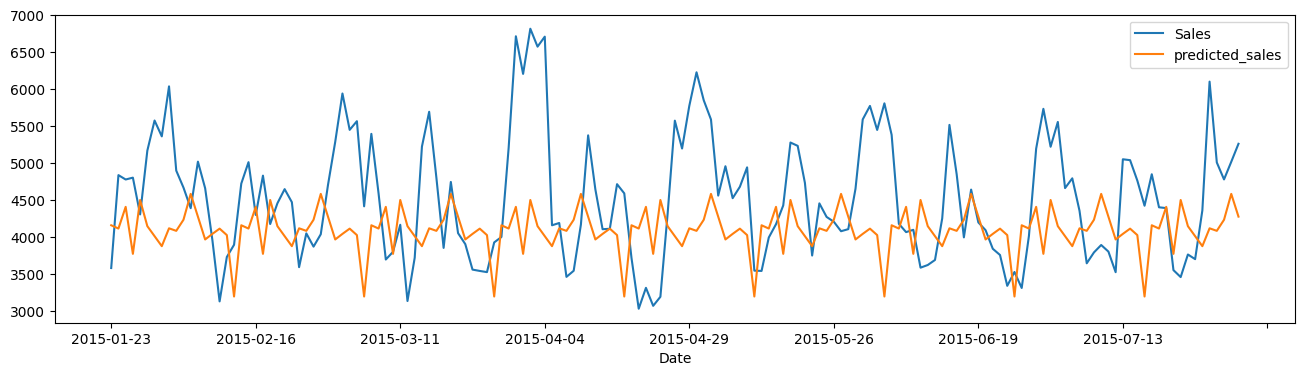

In [300]:
hw_add_season_predictions.set_index('Date')[['Sales', 'predicted_sales']].plot(figsize=[16, 4])
plt.show()

In [297]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(hw_add_season_predictions['Sales'][:12], hw_add_season_predictions['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(hw_add_season_predictions['Sales'][:12], hw_add_season_predictions['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((hw_add_season_predictions['Sales'][:12] - hw_add_season_predictions['predicted_sales'][:12]) / hw_add_season_predictions['Sales'][:12])))))

RMSE: 1913.23
MAPE: 33.31%
RMSPE: 36.30%


In [298]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(hw_add_season_predictions['Sales'][:36], hw_add_season_predictions['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(hw_add_season_predictions['Sales'][:36], hw_add_season_predictions['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((hw_add_season_predictions['Sales'][:36] - hw_add_season_predictions['predicted_sales'][:36]) / hw_add_season_predictions['Sales'][:36])))))

RMSE: 1471.58
MAPE: 24.46%
RMSPE: 28.35%


### Forecasting with linear regression model

#### 1st model

In [353]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [328]:
# Store 1 and open only
data_store_1 = data[(data['Store']==1) & (data['Open']==1)]
data_store_1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1009405,1,1,2013-01-07,7176,785,1,1,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1


In [329]:
# One-hot encode DayOfWeek and select columns needed
data_store_1 = pd.concat([data_store_1, pd.get_dummies(data_store_1['DayOfWeek'], drop_first=True, prefix='dayofweek')], axis=1).set_index('Date')\
    [['Sales', 'Promo', 'StateHoliday', 'SchoolHoliday', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6']]

In [331]:
data_store_1.sort_index(inplace=True)

In [332]:
# Check data type to make sure input data are numerical
data_store_1.dtypes

Sales             int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dayofweek_2       uint8
dayofweek_3       uint8
dayofweek_4       uint8
dayofweek_5       uint8
dayofweek_6       uint8
dtype: object

In [333]:
data_store_1['StateHoliday'].unique()

array(['0', 0], dtype=object)

In [334]:
# Drop StateHoliday, only 1 unique value
data_store_1.drop(columns='StateHoliday', inplace=True)

In [335]:
data_store_1.head()

,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
Date,,,,,,,,
2013-01-02,5530,0,1,0,1,0,0,0
2013-01-03,4327,0,1,0,0,1,0,0
2013-01-04,4486,0,1,0,0,0,1,0
2013-01-05,4997,0,1,0,0,0,0,1
2013-01-07,7176,1,1,0,0,0,0,0


In [336]:
# Split data into train and test data
train = data_store_1.iloc[:624, :]
test = data_store_1.iloc[624:, :]

In [337]:
train.head()

,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
Date,,,,,,,,
2013-01-02,5530,0,1,0,1,0,0,0
2013-01-03,4327,0,1,0,0,1,0,0
2013-01-04,4486,0,1,0,0,0,1,0
2013-01-05,4997,0,1,0,0,0,0,1
2013-01-07,7176,1,1,0,0,0,0,0


In [338]:
# Fit linear model
linear_model_1 = LinearRegression().fit(train.iloc[:, 1:], train.iloc[:, 0])

In [339]:
# Forecast
linear_model_1_predictions = linear_model_1.predict(test.iloc[:, 1:])

In [342]:
test = pd.concat([test.reset_index(), pd.DataFrame(linear_model_1_predictions).rename(columns={0:'predicted_sales'})], axis=1)

In [343]:
test.head()

,Date,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,predicted_sales
0,2015-01-23,3586,0,0,0,0,0,1,0,4170.798634
1,2015-01-24,4840,0,0,0,0,0,0,1,5013.904437
2,2015-01-26,4781,1,0,0,0,0,0,0,5831.241737
3,2015-01-27,4806,1,0,1,0,0,0,0,5339.083126
4,2015-01-28,4310,1,0,0,1,0,0,0,5200.764601


In [345]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:12], test['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:12], test['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:12] - test['predicted_sales'][:12]) / test['Sales'][:12])))))

RMSE: 554.08
MAPE: 10.32%
RMSPE: 12.33%


In [346]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:36], test['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:36], test['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:36] - test['predicted_sales'][:36]) / test['Sales'][:36])))))

RMSE: 588.34
MAPE: 10.95%
RMSPE: 13.99%


<AxesSubplot: xlabel='Date'>

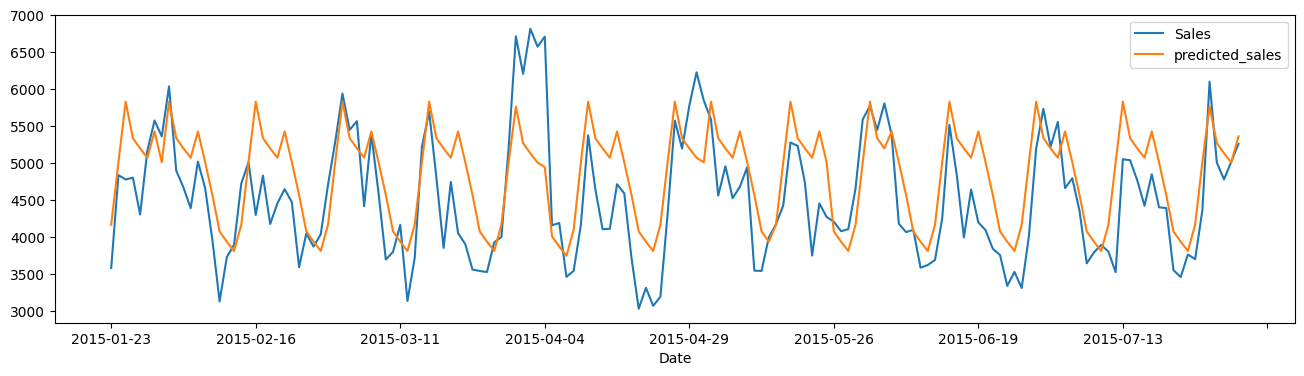

In [347]:
test.set_index('Date')[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [369]:
# Residual plot
# y-axis is standardized residuals
test['residual'] = test['Sales']-test['predicted_sales']
test['standardized_residual'] = StandardScaler().fit_transform(test[['residual']])
test.head()

,Date,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,predicted_sales,residual,standardized_residual
0,2015-01-23,3586,0,0,0,0,0,1,0,4170.798634,-584.798634,-0.476847
1,2015-01-24,4840,0,0,0,0,0,0,1,5013.904437,-173.904437,0.236898
2,2015-01-26,4781,1,0,0,0,0,0,0,5831.241737,-1050.241737,-1.285347
3,2015-01-27,4806,1,0,1,0,0,0,0,5339.083126,-533.083126,-0.387015
4,2015-01-28,4310,1,0,0,1,0,0,0,5200.764601,-890.764601,-1.008326


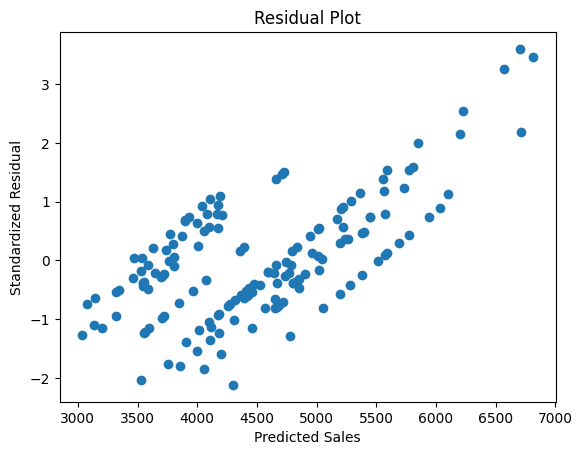

In [370]:
plt.scatter(test['Sales'], test['standardized_residual'])
plt.title('Residual Plot')
plt.xlabel('Predicted Sales')
plt.ylabel('Standardized Residual')
plt.show()

#### 2nd model: Log transform sales
- Model with log transformed sales has better accuracy than the 1st model without any transformation.
- Residuals are approxiamtely normally distributed.
- Residuals don't have constant variance across the range of fitted values. Model tends to overestimate sales. 
- Residuals are positively autocorrelated.

In [371]:
data_store_1_log = data_store_1.copy()

In [373]:
data_store_1_log['log_sales'] = np.log(data_store_1_log['Sales'])
data_store_1_log.head()

,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,log_sales
Date,,,,,,,,,
2013-01-02,5530,0,1,0,1,0,0,0,8.617943
2013-01-03,4327,0,1,0,0,1,0,0,8.372630
2013-01-04,4486,0,1,0,0,0,1,0,8.408717
2013-01-05,4997,0,1,0,0,0,0,1,8.516593
2013-01-07,7176,1,1,0,0,0,0,0,8.878497


In [411]:
# Split data into train and test
train = data_store_1_log.iloc[:624, :]
test = data_store_1_log.iloc[624:, :]

In [387]:
# Fit linear model
linear_model_2 = LinearRegression().fit(train.iloc[:, 1:-1], train.iloc[:, -1])

In [396]:
# Forecast
linear_model_2_predictions = linear_model_2.predict(test.iloc[:, 1:-1])

In [412]:
test = pd.concat([test.reset_index(), pd.DataFrame(np.exp(linear_model_2_predictions)).rename(columns={0:'predicted_sales'})], axis=1)

In [413]:
test.head()

,Date,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,log_sales,predicted_sales
0,2015-01-23,3586,0,0,0,0,0,1,0,8.184793,4121.569138
1,2015-01-24,4840,0,0,0,0,0,0,1,8.484670,4947.627932
2,2015-01-26,4781,1,0,0,0,0,0,0,8.472405,5796.219524
3,2015-01-27,4806,1,0,1,0,0,0,0,8.477620,5269.263331
4,2015-01-28,4310,1,0,0,1,0,0,0,8.368693,5142.314129


In [414]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:12], test['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:12], test['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:12] - test['predicted_sales'][:12]) / test['Sales'][:12])))))

RMSE: 520.28
MAPE: 9.73%
RMSPE: 11.51%


In [415]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:36], test['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:36], test['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:36] - test['predicted_sales'][:36]) / test['Sales'][:36])))))

RMSE: 554.32
MAPE: 10.36%
RMSPE: 13.05%


<AxesSubplot: xlabel='Date'>

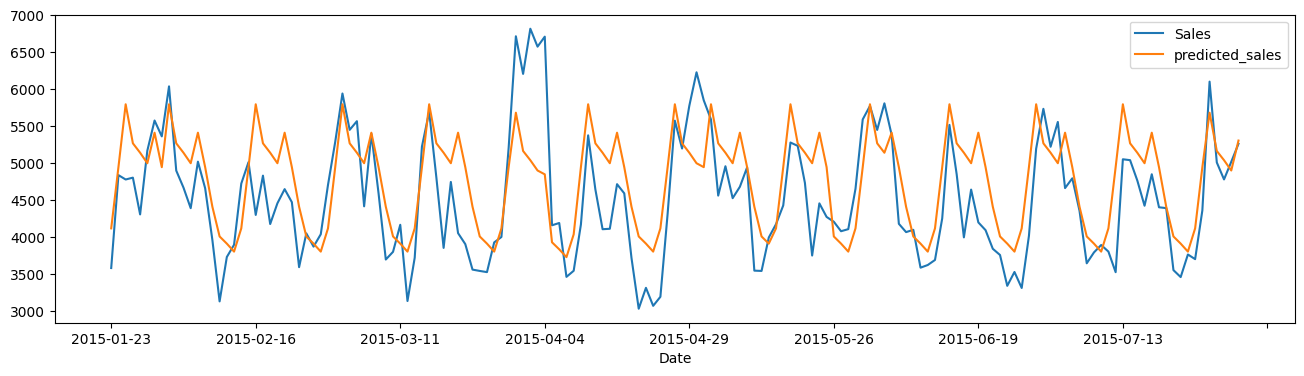

In [407]:
test.set_index('Date')[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [416]:
# Residual plot
# y-axis is standardized residuals
test['residual'] = test['Sales']-test['predicted_sales']
test['standardized_residual'] = StandardScaler().fit_transform(test[['residual']])
test.head()

,Date,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,log_sales,predicted_sales,residual,standardized_residual
0,2015-01-23,3586,0,0,0,0,0,1,0,8.184793,4121.569138,-535.569138,-0.494302
1,2015-01-24,4840,0,0,0,0,0,0,1,8.484670,4947.627932,-107.627932,0.247740
2,2015-01-26,4781,1,0,0,0,0,0,0,8.472405,5796.219524,-1015.219524,-1.326007
3,2015-01-27,4806,1,0,1,0,0,0,0,8.477620,5269.263331,-463.263331,-0.368925
4,2015-01-28,4310,1,0,0,1,0,0,0,8.368693,5142.314129,-832.314129,-1.008853


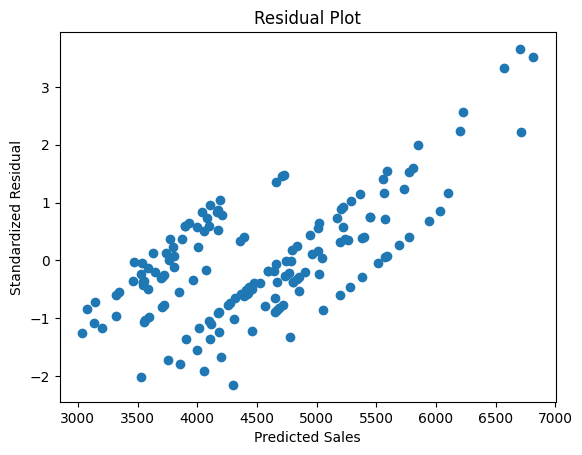

In [417]:
plt.scatter(test['Sales'], test['standardized_residual'])
plt.title('Residual Plot')
plt.xlabel('Predicted Sales')
plt.ylabel('Standardized Residual')
plt.show()

<AxesSubplot: xlabel='residual', ylabel='Density'>

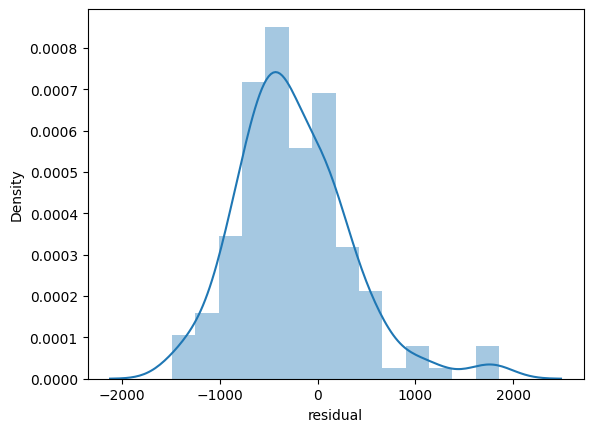

In [420]:
sns.distplot(test['residual'])

In [430]:
# Residuals are positively autocorrelated.
from statsmodels.stats.stattools import durbin_watson
durbin_watson(test['residual'])

0.6973544786917037

In [431]:
# Ljung Box test for autocorrelation
import statsmodels.api as sm
sm.stats.acorr_ljungbox(test['residual'], lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,135.145095,4.154992e-24


#### 3rd model: Log transform sales, remove outliers in train data.
- Outliers are defined using boxplot approach, below 25th-1.5\*IQR and above 75th+1.5*IQR
- Outliers are based on sales, not log transformed sales
- Model performs better than the 2nd model

In [544]:
# Split data into train and test
train = data_store_1_log.iloc[:624, :]
test = data_store_1_log.iloc[624:, :]

In [545]:
sales_iqr = np.percentile(train['Sales'], 75) - np.percentile(train['Sales'], 25)
sales_lower_bound = np.percentile(train['Sales'], 25) - 1.5*sales_iqr
sales_upper_bound = np.percentile(train['Sales'], 75) + 1.5*sales_iqr
print(sales_lower_bound, sales_upper_bound)

1938.5 7480.5


In [546]:
train_no_outlier = train[train['Sales'].between(sales_lower_bound, sales_upper_bound)]

In [547]:
# Fit linear model
linear_model_3 = LinearRegression().fit(train_no_outlier.iloc[:, 1:-1], train_no_outlier.iloc[:, -1])

In [548]:
# Forecast
linear_model_3_predictions = linear_model_3.predict(test.iloc[:, 1:-1])

In [549]:
test = pd.concat([test.reset_index(), pd.DataFrame(np.exp(linear_model_3_predictions)).rename(columns={0:'predicted_sales'})], axis=1)

In [529]:
test.head()

,Date,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,log_sales,predicted_sales
0,2015-01-23,3586,0,0,0,0,0,1,0,8.184793,4088.763659
1,2015-01-24,4840,0,0,0,0,0,0,1,8.484670,4905.202826
2,2015-01-26,4781,1,0,0,0,0,0,0,8.472405,5645.660935
3,2015-01-27,4806,1,0,1,0,0,0,0,8.477620,5212.038757
4,2015-01-28,4310,1,0,0,1,0,0,0,8.368693,5099.697213


In [530]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:12], test['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:12], test['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:12] - test['predicted_sales'][:12]) / test['Sales'][:12])))))

RMSE: 488.65
MAPE: 9.32%
RMSPE: 10.72%


In [531]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:36], test['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:36], test['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:36] - test['predicted_sales'][:36]) / test['Sales'][:36])))))

RMSE: 522.82
MAPE: 9.95%
RMSPE: 12.22%


<AxesSubplot: xlabel='Date'>

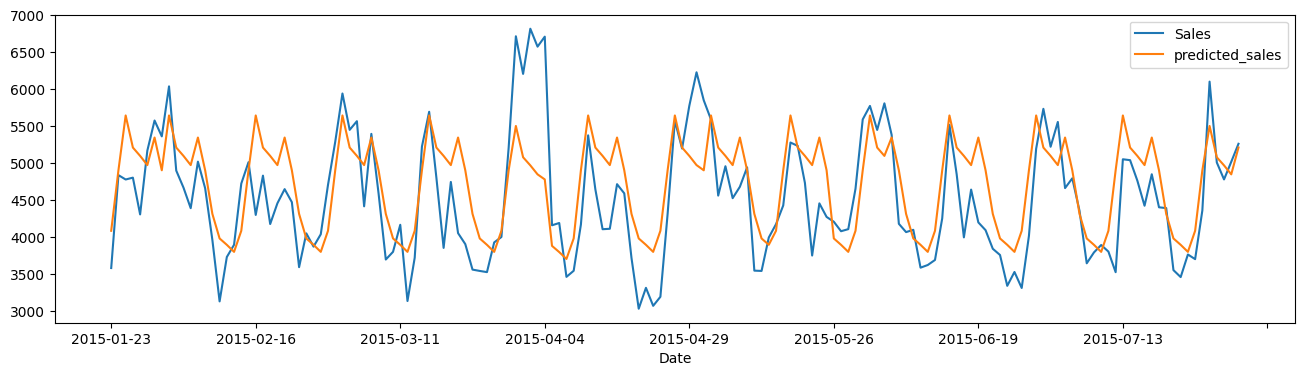

In [535]:
test.set_index('Date')[['Sales', 'predicted_sales']].plot(figsize=[16, 4])

In [532]:
# Residual plot
# y-axis is standardized residuals
test['residual'] = test['Sales']-test['predicted_sales']
test['standardized_residual'] = StandardScaler().fit_transform(test[['residual']])
test.head()

,Date,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,log_sales,predicted_sales,residual,standardized_residual
0,2015-01-23,3586,0,0,0,0,0,1,0,8.184793,4088.763659,-502.763659,-0.529630
1,2015-01-24,4840,0,0,0,0,0,0,1,8.484670,4905.202826,-65.202826,0.228074
2,2015-01-26,4781,1,0,0,0,0,0,0,8.472405,5645.660935,-864.660935,-1.156310
3,2015-01-27,4806,1,0,1,0,0,0,0,8.477620,5212.038757,-406.038757,-0.362136
4,2015-01-28,4310,1,0,0,1,0,0,0,8.368693,5099.697213,-789.697213,-1.026499


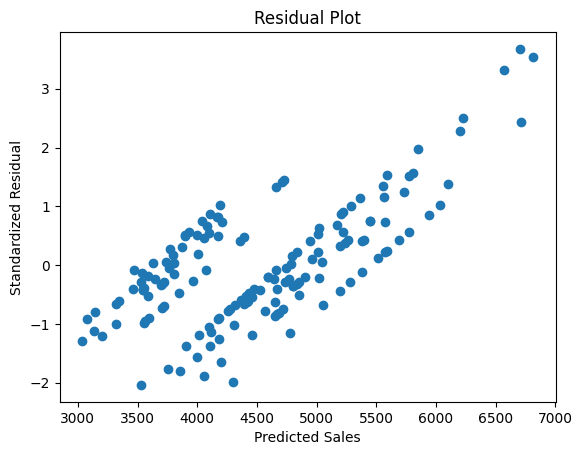

In [533]:
plt.scatter(test['Sales'], test['standardized_residual'])
plt.title('Residual Plot')
plt.xlabel('Predicted Sales')
plt.ylabel('Standardized Residual')
plt.show()

<AxesSubplot: xlabel='residual', ylabel='Density'>

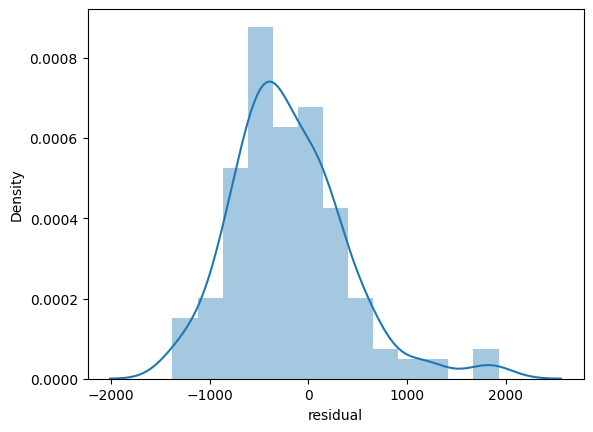

In [534]:
sns.distplot(test['residual'])

#### 4th model: Log transform sales, remove outliers in train data.
- Outliers are based on log transformed sales
- Model performs worse than the 3rd model

In [454]:
# Split data into train and test
train = data_store_1_log.iloc[:624, :]
test = data_store_1_log.iloc[624:, :]

In [455]:
sales_iqr = np.percentile(train['log_sales'], 75) - np.percentile(train['log_sales'], 25)
sales_lower_bound = np.percentile(train['log_sales'], 25) - 1.5*sales_iqr
sales_upper_bound = np.percentile(train['log_sales'], 75) + 1.5*sales_iqr
print(sales_lower_bound, sales_upper_bound)

7.853714763942729 9.039084436395061


In [456]:
train_no_outlier = train[train['log_sales'].between(sales_lower_bound, sales_upper_bound)]

In [457]:
# Fit linear model
linear_model_4 = LinearRegression().fit(train_no_outlier.iloc[:, 1:-1], train_no_outlier.iloc[:, -1])

In [458]:
# Forecast
linear_model_4_predictions = linear_model_4.predict(test.iloc[:, 1:-1])

In [459]:
test = pd.concat([test.reset_index(), pd.DataFrame(np.exp(linear_model_4_predictions)).rename(columns={0:'predicted_sales'})], axis=1)

In [460]:
test.head()

,Date,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,log_sales,predicted_sales
0,2015-01-23,3586,0,0,0,0,0,1,0,8.184793,4123.836737
1,2015-01-24,4840,0,0,0,0,0,0,1,8.484670,4955.042492
2,2015-01-26,4781,1,0,0,0,0,0,0,8.472405,5725.590650
3,2015-01-27,4806,1,0,1,0,0,0,0,8.477620,5312.648708
4,2015-01-28,4310,1,0,0,1,0,0,0,8.368693,5159.934173


In [461]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:12], test['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:12], test['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:12] - test['predicted_sales'][:12]) / test['Sales'][:12])))))

RMSE: 524.48
MAPE: 9.91%
RMSPE: 11.60%


In [462]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:36], test['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:36], test['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:36] - test['predicted_sales'][:36]) / test['Sales'][:36])))))

RMSE: 552.30
MAPE: 10.37%
RMSPE: 12.97%


#### 5th model: Apply first difference to Sales
- Predictions are poor.

In [477]:
# Split data into train and test data
train = data_store_1.iloc[:624, :]
test = data_store_1.iloc[624:, :]

In [482]:
train['lastday_sales'] = train['Sales'].shift(1)
train['first_differenced_sales'] = train['Sales']-train['lastday_sales']
train.head()

,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,lastday_sales,first_differenced_sales
Date,,,,,,,,,,
2013-01-02,5530,0,1,0,1,0,0,0,NaN,NaN
2013-01-03,4327,0,1,0,0,1,0,0,5530.0,-1203.0
2013-01-04,4486,0,1,0,0,0,1,0,4327.0,159.0
2013-01-05,4997,0,1,0,0,0,0,1,4486.0,511.0
2013-01-07,7176,1,1,0,0,0,0,0,4997.0,2179.0


In [493]:
train_nona = train.iloc[1:, :]
train_nona.head()

,Sales,Promo,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,lastday_sales,first_differenced_sales
Date,,,,,,,,,,
2013-01-03,4327,0,1,0,0,1,0,0,5530.0,-1203.0
2013-01-04,4486,0,1,0,0,0,1,0,4327.0,159.0
2013-01-05,4997,0,1,0,0,0,0,1,4486.0,511.0
2013-01-07,7176,1,1,0,0,0,0,0,4997.0,2179.0
2013-01-08,5580,1,1,1,0,0,0,0,7176.0,-1596.0


In [494]:
# Fit linear model
linear_model_5 = LinearRegression().fit(train_nona.iloc[:, 1:-2], train_nona.iloc[:, -1])

In [495]:
# Forecast
linear_model_5_predictions = linear_model_5.predict(test.iloc[:, 1:])

In [510]:
prediction_list = [3492]
for i in range(len(linear_model_5_predictions)):
    prediction_list.append(prediction_list[i] + linear_model_5_predictions[i])

In [520]:
test = pd.concat([test.reset_index(), pd.DataFrame(prediction_list[1:]).rename(columns={0:'predicted_sales'})], axis=1)

In [521]:
# Check performance of predictions for the next 2 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:12], test['predicted_sales'][:12], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:12], test['predicted_sales'][:12])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:12] - test['predicted_sales'][:12]) / test['Sales'][:12])))))

RMSE: 802.78
MAPE: 13.44%
RMSPE: 15.35%


In [522]:
# Check performance of predictions for the next 6 weeks
print('RMSE: {:.2f}'.format(mean_squared_error(test['Sales'][:36], test['predicted_sales'][:36], squared=False)))
print('MAPE: {:.2%}'.format(mean_absolute_percentage_error(test['Sales'][:36], test['predicted_sales'][:36])))
print('RMSPE: {:.2%}'.format(np.sqrt(np.mean(np.square((test['Sales'][:36] - test['predicted_sales'][:36]) / test['Sales'][:36])))))

RMSE: 750.02
MAPE: 13.74%
RMSPE: 17.51%


### Test forecasts with SARIMAX models

#### Process test data

In [729]:
data_test = pd.read_csv('test.csv')

In [730]:
data_test.set_index('Date', inplace=True)
data_test.sort_index(inplace=True)
data_test.index.freq = 'D'

In [731]:
data_test.shape

(41088, 7)

In [732]:
data_model = data_test[data_test['Open']==1][['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday']]

In [733]:
# One-hot encode day of week
data_model = pd.concat([data_model.reset_index(), pd.get_dummies(data_model['DayOfWeek'], prefix='dayofweek').reset_index(drop=True)], axis=1)

In [734]:
# Drop DayOfWeek
data_model.drop(columns='DayOfWeek', inplace=True)

In [735]:
data_model['StateHoliday'].unique()

array(['0', 'a'], dtype=object)

In [558]:
# Replace a in StateHoliday with 1
data_model['StateHoliday'] = data_model['StateHoliday'].str.replace('a', '1')
data_model['StateHoliday'].value_counts()

0    35067
1       26
Name: StateHoliday, dtype: int64

In [559]:
# Format StateHoliday as int64, since SARIMAX won't be able to train data in object type
data_model['StateHoliday'] = data_model['StateHoliday'].astype(np.int64)

#### Process train data

In [561]:
data_train = data.set_index('Date')
data_train.sort_index(inplace=True)
data_train.index.freq = 'D'

In [562]:
data_train = data_train[data_train['Open']==1][['Sales', 'Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday']]

In [563]:
dayofweek = pd.DataFrame(OneHotEncoder().fit_transform(data_train[['DayOfWeek']]).toarray())
dayofweek.rename(columns={0:'dayofweek_1', 1:'dayofweek_2', 2:'dayofweek_3', 3:'dayofweek_4', \
    4:'dayofweek_5', 5:'dayofweek_6', 6:'dayofweek_7'}, inplace=True)
dayofweek = dayofweek.astype(np.int64)
dayofweek.index = data_train.index

In [564]:
data_train = pd.concat([data_train.reset_index(), dayofweek.reset_index(drop=True)], axis=1).set_index('Date')
data_train.head()

,Sales,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7
Date,,,,,,,,,,,,,
2013-01-01,3139,353,2,0,a,1,0,1,0,0,0,0,0
2013-01-01,2401,335,2,0,a,1,0,1,0,0,0,0,0
2013-01-01,2646,512,2,0,a,1,0,1,0,0,0,0,0
2013-01-01,3113,494,2,0,a,1,0,1,0,0,0,0,0
2013-01-01,2907,530,2,0,a,1,0,1,0,0,0,0,0


In [565]:
data_train.dtypes

Sales             int64
Store             int64
DayOfWeek         int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dayofweek_1       int64
dayofweek_2       int64
dayofweek_3       int64
dayofweek_4       int64
dayofweek_5       int64
dayofweek_6       int64
dayofweek_7       int64
dtype: object

In [566]:
# Convert StateHoliday to int64 since input data for SARIMAX needs to be integer type
data_train['StateHoliday'].unique()

array(['a', '0', 'b', 'c', 0], dtype=object)

In [567]:
# Since test data only have 0 and a for StateHoliday, replace values not equal to 0 as 1 in train data
data_train.loc[data_train['StateHoliday']=='0', 'StateHoliday'] = 0
data_train.loc[data_train['StateHoliday']!=0, 'StateHoliday'] = 1

In [568]:
data_train['StateHoliday'].unique()

array([1, 0], dtype=object)

In [569]:
data_train['StateHoliday'] = data_train['StateHoliday'].astype(np.int64)

In [570]:
# Remove DayOfWeek
data_train.drop(columns='DayOfWeek', inplace=True)

In [97]:
# Check if data_train contains all the stores included in data_model since the goal is to fit model for each store, and use the model to make predictions
store_not_in_train = []
for i in data_model['Store'].unique():
    if i not in data_train['Store'].unique():
        store_not_in_train.append(i)

In [98]:
# All stores in data_model exist in data_train, so model can be fit for each store.
store_not_in_train

[]

In [108]:
data_train.head()

,Sales,Store,Promo,StateHoliday,SchoolHoliday,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7
Date,,,,,,,,,,,,
2013-01-01,3139,353,0,1,1,0,1,0,0,0,0,0
2013-01-01,2401,335,0,1,1,0,1,0,0,0,0,0
2013-01-01,2646,512,0,1,1,0,1,0,0,0,0,0
2013-01-01,3113,494,0,1,1,0,1,0,0,0,0,0
2013-01-01,2907,530,0,1,1,0,1,0,0,0,0,0


#### Produce forecasts
- Final RMSPE is 0.16899

In [83]:
# store_forecast has unique store ids in data_model
store_forecast = list(data_model['Store'].unique())

In [246]:
forecast_results = pd.DataFrame()
for i in range(294, len(store_forecast)):
    sarimax_model = SARIMAX(data_train[data_train['Store']==store_forecast[i]]['Sales'], exog=data_train[data_train['Store']==store_forecast[i]].iloc[:, 2:], order=(3, 0, 3), seasonal_order=(2, 0, 2, 6), enforce_stationarity=False, initialization='approximate_diffuse').fit(disp=False)
    predictions = sarimax_model.forecast(len(data_model[data_model['Store']==store_forecast[i]]), exog=data_model[data_model['Store']==store_forecast[i]].iloc[:, 2:])
    data_model_predictions = pd.concat([data_model[data_model['Store']==store_forecast[i]].reset_index(drop=True), pd.DataFrame(predictions).reset_index(drop=True)], axis=1)
    forecast_results = pd.concat([forecast_results, data_model_predictions], axis=0, ignore_index=True)

In [267]:
forecast_results.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,predicted_mean_x,predicted_mean_y,Sales
0,2015-08-01,1115,0,0,1,0,0,0,0,0,1,0,7345.251853,NaN,7345.251853
1,2015-08-01,378,0,0,0,0,0,0,0,0,1,0,7482.765230,NaN,7482.765230
2,2015-08-01,377,0,0,0,0,0,0,0,0,1,0,9290.068902,NaN,9290.068902
3,2015-08-01,373,0,0,0,0,0,0,0,0,1,0,5232.028521,NaN,5232.028521
4,2015-08-01,372,0,0,0,0,0,0,0,0,1,0,8389.107528,NaN,8389.107528


In [274]:
data_test_results = data_test.reset_index().merge(forecast_results, how='left', on=['Date', 'Store'])
data_test_results.head()

,Date,Id,Store,DayOfWeek,Open,Promo_x,StateHoliday_x,SchoolHoliday_x,Promo_y,StateHoliday_y,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,predicted_mean_x,predicted_mean_y,Sales
0,2015-08-01,41088,1115,6,1.0,0,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7345.251853,NaN,7345.251853
1,2015-08-01,40523,378,6,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7482.765230,NaN,7482.765230
2,2015-08-01,40522,377,6,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9290.068902,NaN,9290.068902
3,2015-08-01,40521,373,6,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5232.028521,NaN,5232.028521
4,2015-08-01,40520,372,6,1.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8389.107528,NaN,8389.107528


In [278]:
data_test_results.loc[data_test_results['Sales'].isnull(), 'Sales'] = 0

In [280]:
data_test_results[['Id', 'Sales']].to_csv('sample_submission.csv', index=False)

### Test forecast with linear regression model
- Log transform sales and remove outliers in sales
- Store-specific linear model

In [572]:
data_train['log_sales'] = np.log(data_train['Sales'])
data_train.drop(columns='dayofweek_1', inplace=True)
data_train.head()

,Sales,Store,Promo,StateHoliday,SchoolHoliday,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,log_sales
Date,,,,,,,,,,,,
2013-01-01,3139,353,0,1,1,1,0,0,0,0,0,8.051660
2013-01-01,2401,335,0,1,1,1,0,0,0,0,0,7.783641
2013-01-01,2646,512,0,1,1,1,0,0,0,0,0,7.880804
2013-01-01,3113,494,0,1,1,1,0,0,0,0,0,8.043342
2013-01-01,2907,530,0,1,1,1,0,0,0,0,0,7.974877


In [596]:
data_model.drop(columns='dayofweek_1', inplace=True)

In [636]:
unique_store = data_model['Store'].unique()

In [661]:
results = pd.DataFrame()
for i in range(len(unique_store)):
    data_train_store = data_train[data_train['Store']==unique_store[i]]
    sales_iqr = np.percentile(data_train_store['Sales'], 75) - np.percentile(data_train_store['Sales'], 25)
    sales_lower_bound = np.percentile(data_train_store['Sales'], 25) - 1.5*sales_iqr
    sales_upper_bound = np.percentile(data_train_store['Sales'], 75) + 1.5*sales_iqr
    data_train_store_no_outlier = data_train_store[(data_train_store['Sales'].between(sales_lower_bound, sales_upper_bound)) & (data_train_store['Sales']>0)]
    linear_model = LinearRegression().fit(data_train_store_no_outlier.iloc[:, 2:-1], data_train_store_no_outlier.iloc[:, -1])
    predictions = linear_model.predict(data_model[data_model['Store']==unique_store[i]].iloc[:, 2:])
    predictions_df = pd.concat([data_model[data_model['Store']==unique_store[i]].reset_index(drop=True), pd.DataFrame(np.exp(predictions)).rename(columns={0:'Sales'})], \
        axis=1)
    results = pd.concat([results, predictions_df], ignore_index=True)

In [673]:
prediction_results = data_test.reset_index().merge(results[['Date', 'Store', 'Sales']], how='left', on=['Date', 'Store'])
prediction_results.loc[prediction_results['Open']!=1, 'Sales'] = 0

In [676]:
prediction_results[['Id', 'Sales']].to_csv('linear_predictions.csv', index=False)

### Test forecast with 2nd linear regression model
- One linear model is fit, not store specific model
- Model has much worse performance than store specific model

In [679]:
sales_lower_bound = np.percentile(data_train['Sales'], 25) - 1.5*sales_iqr
sales_upper_bound = np.percentile(data_train['Sales'], 75) + 1.5*sales_iqr
data_train_no_outlier = data_train[(data_train['Sales'].between(sales_lower_bound, sales_upper_bound)) & (data_train['Sales']>0)]

In [695]:
linear_model = LinearRegression().fit(data_train_no_outlier.iloc[:, 2:-1], data_train_no_outlier.iloc[:, -1])
predictions = linear_model.predict(data_model.iloc[:, 2:])
predictions_df = pd.concat([data_model, pd.DataFrame(np.exp(predictions)).rename(columns={0:'Sales'})], axis=1)

In [697]:
prediction_results = data_test.reset_index().merge(predictions_df[['Date', 'Store', 'Sales']], how='left', on=['Date', 'Store'])
prediction_results.loc[prediction_results['Open']!=1, 'Sales'] = 0

In [698]:
prediction_results[['Id', 'Sales']].to_csv('linear_predictions_all.csv', index=False)